## Overview

This notebook provides a comprehensive demonstration of several baseline algorithms used in First-Price Auction (FPA) and VCG (Vickrey–Clarke–Groves) auction scenarios. We showcase both individual performances and comparative analyses of the following algorithms:

1. ALM
2. TA-PID
3. M-PID
4. Mystique
5. BROI

## Purpose

The main objectives of this notebook are:

1. To illustrate the implementation and behavior of each baseline algorithm
2. To compare the performance of these algorithms

Feel free to add your own bidding algorithms to our benchmark 😊


# Baselines comparison

In [6]:
import sys
sys.path.append("../")

%load_ext autoreload
%autoreload 2
    
import pandas as pd
import numpy as np
import optuna
import pickle
import matplotlib.pyplot as plt

from functools import partial

from simulator.simulation.modules import Campaign
from simulator.simulation.utils_visualization import data_prep_vis, plot_history_article
from simulator.simulation.simulate import simulate_campaign
from simulator.validation.check_results import autobidder_check

# import baselines:
from simulator.model.linear_bidder import LinearBidder
from simulator.model.ta_pid import TAPIDBidder
from simulator.model.m_pid import MPIDBidder
from simulator.model.mystique import Mystique
from simulator.model.broi_bidder import BROI
from simulator.model.traffic import Traffic
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [11]:
auction_mode = 'FPA' # you may also choose the 'VCG' mode

# data paths
campaigns_path = f"../../data/{auction_mode.lower()}/campaigns_{auction_mode.lower()}_filtered_train_final.csv"
stats_path = f"../data/{auction_mode.lower()}/stats_{auction_mode.lower()}_filtered_train_final.csv"

In [12]:
campaign_df = pd.read_csv(campaigns_path)
stats_df = pd.read_csv(stats_path)

In [13]:
campaign_df.sample(1)

,campaign_id,loc_id,item_id,campaign_start_date,campaign_start,campaign_end,auction_budget,microcat_ext,logical_category,region_id,campaign_end_date
39,73133884,625390,3418575600,1986-10-13,529572512,529831712,190.08,3772,2.35,625330,1986-10-16


In [14]:
stats_df.sample(3)

,campaign_id,period,item_id,contact_price_bin,AuctionVisibilitySurplus,AuctionClicksSurplus,AuctionContactsSurplus,AuctionWinBidSurplus,CTRPredicts,CRPredicts,AuctionCount,platform_p
14192,72797967,529750800,4046329200,44.0,1.031878,0.062734,0.000543,53.50,0.012305,0.016367,7,NaN
134875,81621443,530388000,3828854300,45.0,0.790313,0.106161,0.014464,109.10,0.047450,0.176790,7,[0. 0. 0.6667 0.3333]
57862,76896980,530283600,4053006200,45.0,2.738471,0.200625,0.002837,206.47,0.023395,0.016301,13,NaN


# One campaign's example

In [15]:
campaign_data = campaign_df.sample(1).iloc[0]
campaign_stats = stats_df[stats_df.campaign_id == campaign_data["campaign_id"]].copy()
print(campaign_data.shape, campaign_stats.shape)

(11,) (4416, 12)


## Linear Bidder

In [16]:
campaign_example = Campaign(
    item_id= campaign_data['item_id'],
    campaign_id=int(campaign_data['campaign_id']),
    loc_id=int(campaign_data["loc_id"]),
    region_id=int(campaign_data["region_id"]),
    logical_category=campaign_data["logical_category"],
    microcat_ext=int(campaign_data["microcat_ext"]),
    campaign_start=int(campaign_data["campaign_start"]),
    campaign_end=int(campaign_data["campaign_end"]),
    initial_balance=campaign_data['auction_budget'],
    balance=campaign_data['auction_budget'],
    curr_time=int(campaign_data["campaign_start"]),
    prev_time=int(campaign_data["campaign_start"]),
    prev_balance=campaign_data['auction_budget'],
)
print("Budget ", campaign_data['auction_budget']) 
print("Length hours ", (campaign_data['campaign_end'] - campaign_data['campaign_start']) // 3600)

Budget  1935.36
Length hours  120


In [20]:
simulation_history = simulate_campaign(
    campaign=campaign_example,
    bidder=LinearBidder(),
    stats_file=campaign_stats,
    auction_mode=auction_mode
)

In [21]:
df = simulation_history.to_data_frame()
viz_data_linear = data_prep_vis(df)
df.head(2)

,curr_time,curr_timestamp,campaign_start_time,campaign_end_time,campaign_id,balance,initial_balance,clicks,contacts,bid,loc_id,region_id,logical_category,microcat_ext,prev_timestamp,desired_clicks,desired_time,spend_history,clicks_history,tr_share,tr_share_cs,price_bin,cpc
0,1986-10-20 16:00:00,530197200,530196847,530628847,82325409,0.0,1935.36,168.229446,3.794254,580.608,640860,640310,2.5,3807,530193600,0,0,3.894227,0.253628,0.010787,0.010787,34.905778,0.023148


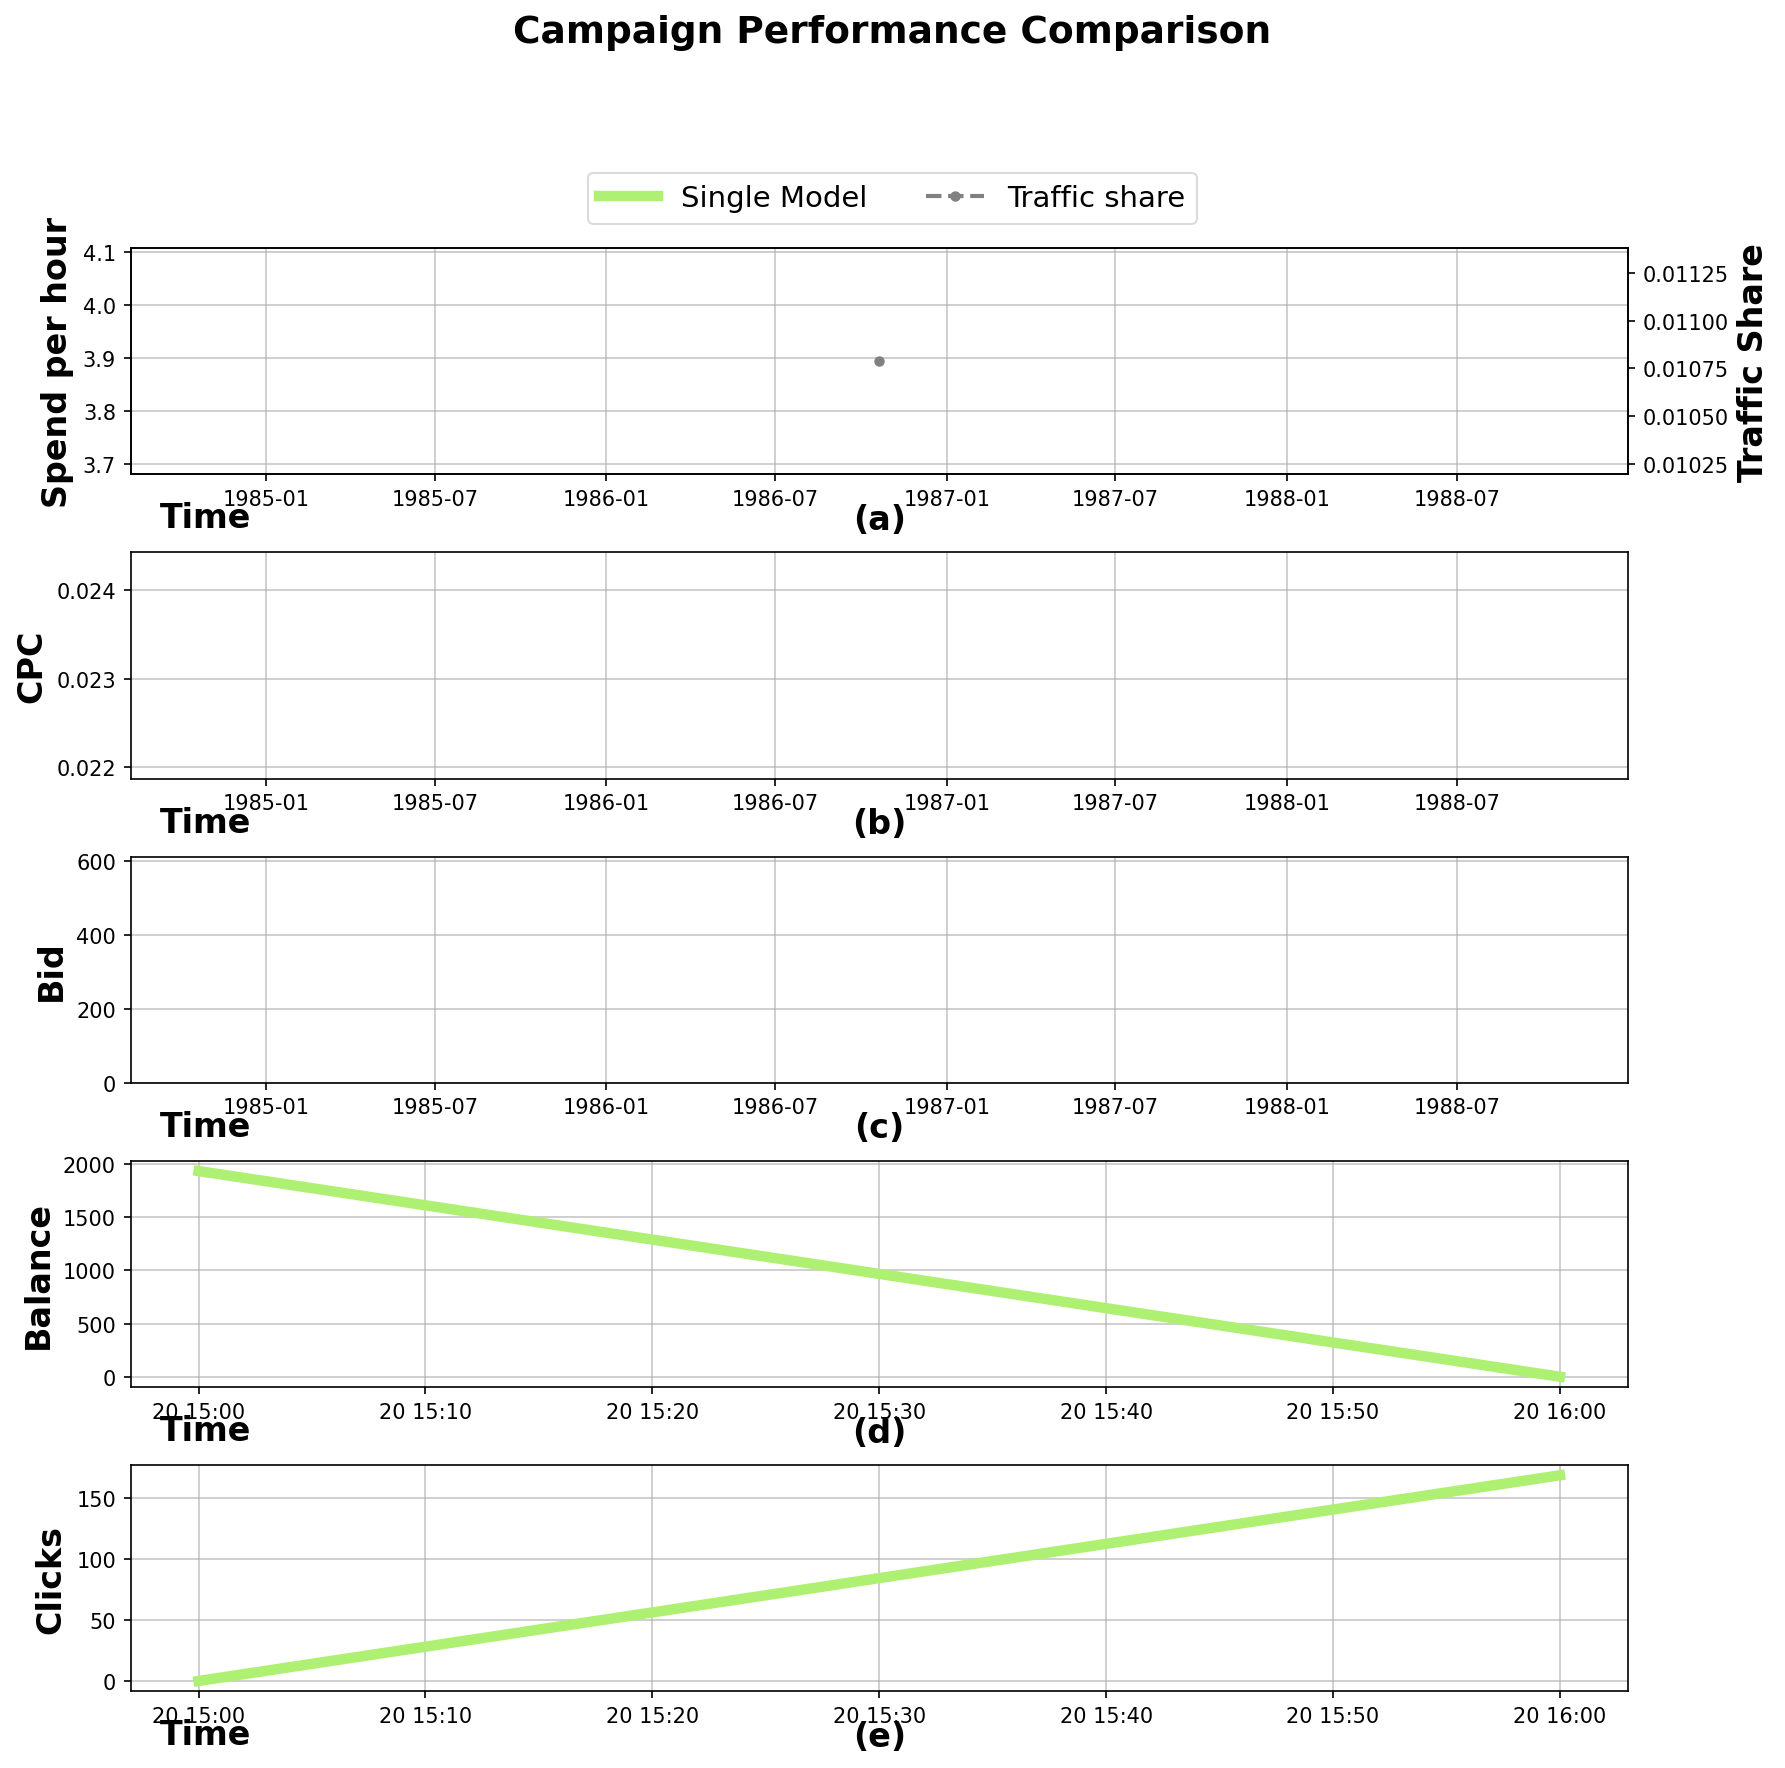

In [24]:
fig = plot_history_article(viz_data_linear)

### BROI

In [25]:
campaign_example = Campaign(
    item_id= campaign_data['item_id'],
    campaign_id=int(campaign_data['campaign_id']),
    loc_id=int(campaign_data["loc_id"]),
    region_id=int(campaign_data["region_id"]),
    logical_category=campaign_data["logical_category"],
    microcat_ext=int(campaign_data["microcat_ext"]),
    campaign_start=int(campaign_data["campaign_start"]),
    campaign_end=int(campaign_data["campaign_end"]),
    initial_balance=campaign_data['auction_budget'],
    balance=campaign_data['auction_budget'],
    curr_time=int(campaign_data["campaign_start"]),
    prev_time=int(campaign_data["campaign_start"]),
    prev_balance=campaign_data['auction_budget'],
)
print("Budget ", campaign_data['auction_budget']) 
print("Length hours ", (campaign_data['campaign_end'] - campaign_data['campaign_start']) // 3600)

Budget  1935.36
Length hours  120


In [26]:
simulation_history = simulate_campaign(
    campaign=campaign_example,
    bidder=BROI(),
    stats_file=campaign_stats,
    auction_mode=auction_mode
)

In [27]:
df = simulation_history.to_data_frame()
viz_data_broi = data_prep_vis(df)
df.head(2)

,curr_time,curr_timestamp,campaign_start_time,campaign_end_time,campaign_id,balance,initial_balance,clicks,contacts,bid,loc_id,region_id,logical_category,microcat_ext,prev_timestamp,desired_clicks,desired_time,spend_history,clicks_history,tr_share,tr_share_cs,price_bin,cpc
0,1986-10-20 16:00:00,530197200,530196847,530628847,82325409,1935.360000,1935.36,0.000000,0.000000,6.191736,640860,640310,2.5,3807,530193600,0,0,0.000000,0.000000,0.010787,0.010787,10.0,0.000000
1,1986-10-20 17:00:00,530200800,530196847,530628847,82325409,1935.214611,1935.36,0.759894,0.023481,6.191736,640860,640310,2.5,3807,530197200,0,0,0.145389,0.759894,0.010435,0.021222,10.0,0.191327


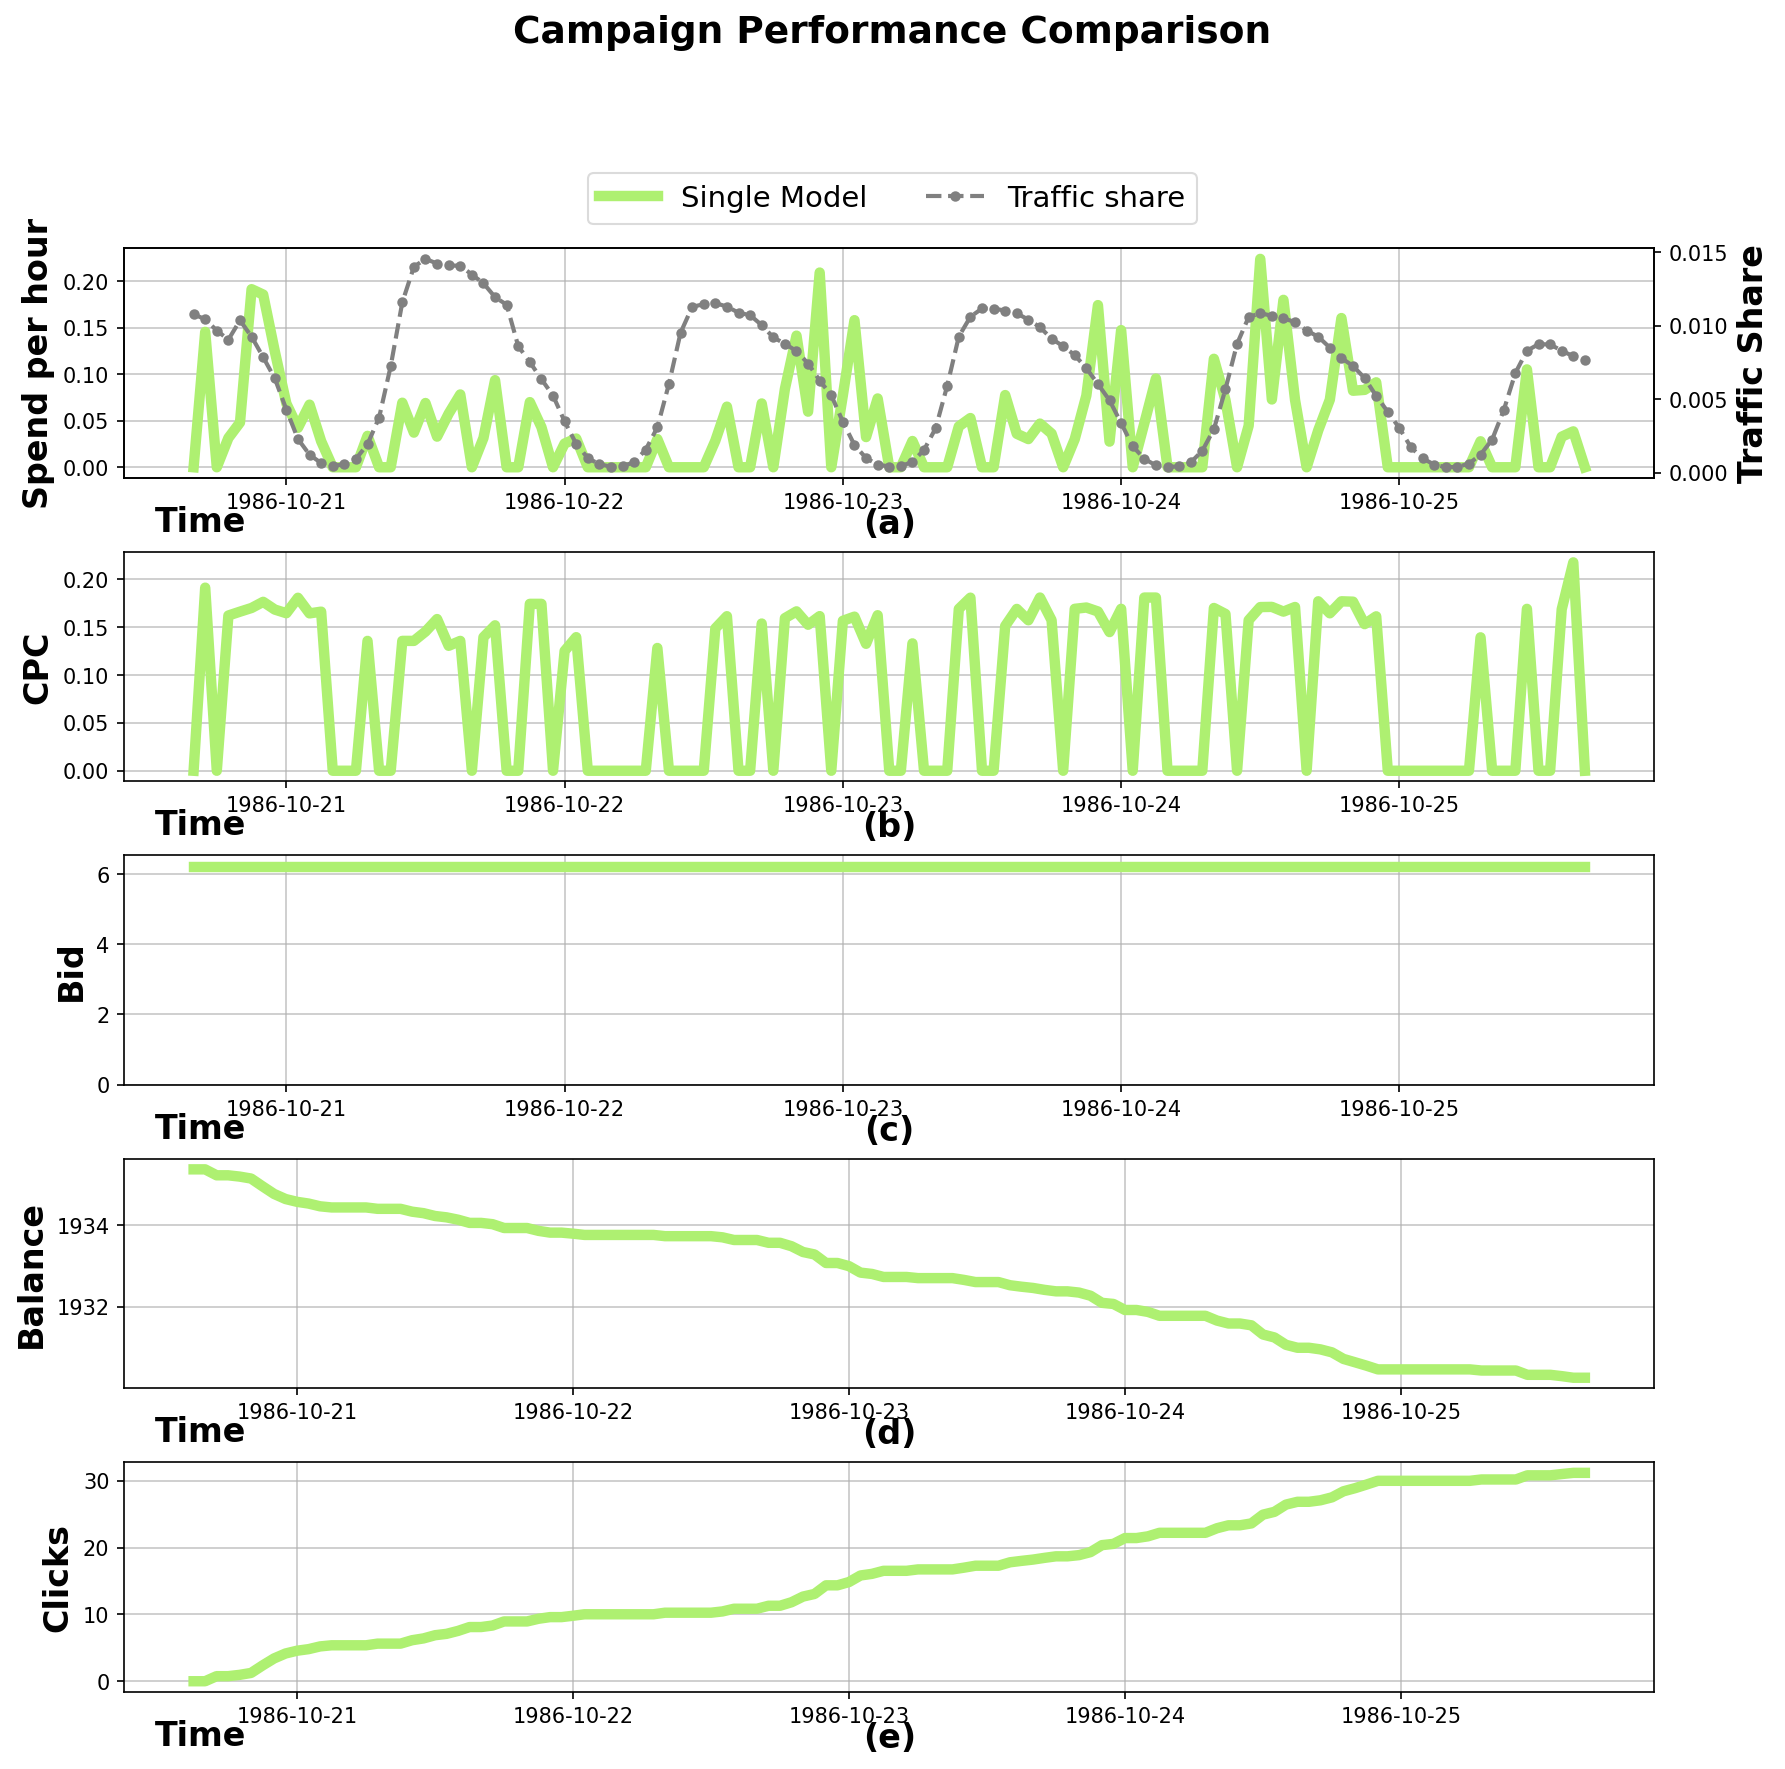

In [28]:
fig = plot_history_article(viz_data_broi)

## TA-PID Bidder

In [29]:
# refreshing Campaign
campaign_example = Campaign(
    item_id=campaign_data['item_id'],
    campaign_id=int(campaign_data['campaign_id']),
    loc_id=int(campaign_data["loc_id"]),
    region_id=int(campaign_data["region_id"]),
    logical_category=campaign_data["logical_category"],
    microcat_ext=int(campaign_data["microcat_ext"]),
    campaign_start=int(campaign_data["campaign_start"]),
    campaign_end=int(campaign_data["campaign_end"]),
    initial_balance=campaign_data['auction_budget'],
    balance=campaign_data['auction_budget'],
    curr_time=int(campaign_data["campaign_start"]),
    prev_time=int(campaign_data["campaign_start"]),
    prev_balance=campaign_data['auction_budget'],
)
print("Budget ", campaign_data['auction_budget']) 
print("Length hours ", (campaign_data['campaign_end'] - campaign_data['campaign_start']) // 3600)

Budget  1935.36
Length hours  120


In [30]:
simulation_history = simulate_campaign(
    campaign=campaign_example,
    bidder=TAPIDBidder(),
    stats_file=campaign_stats,
    auction_mode=auction_mode
)

In [31]:
df = simulation_history.to_data_frame()
viz_data_ta_pid = data_prep_vis(df)
df.head(2)

,curr_time,curr_timestamp,campaign_start_time,campaign_end_time,campaign_id,balance,initial_balance,clicks,contacts,bid,loc_id,region_id,logical_category,microcat_ext,prev_timestamp,desired_clicks,desired_time,spend_history,clicks_history,tr_share,tr_share_cs,price_bin,cpc
0,1986-10-20 16:00:00,530197200,530196847,530628847,82325409,1930.531841,1935.36,0.255018,0.006742,716.0832,640860,640310,2.5,3807,530193600,0,0,4.828159,0.255018,0.010787,0.010787,36.056057,18.932645
1,1986-10-20 17:00:00,530200800,530196847,530628847,82325409,1877.038219,1935.36,3.028333,0.081446,716.0832,640860,640310,2.5,3807,530197200,0,0,53.493622,2.773315,0.010435,0.021222,36.056057,19.288690


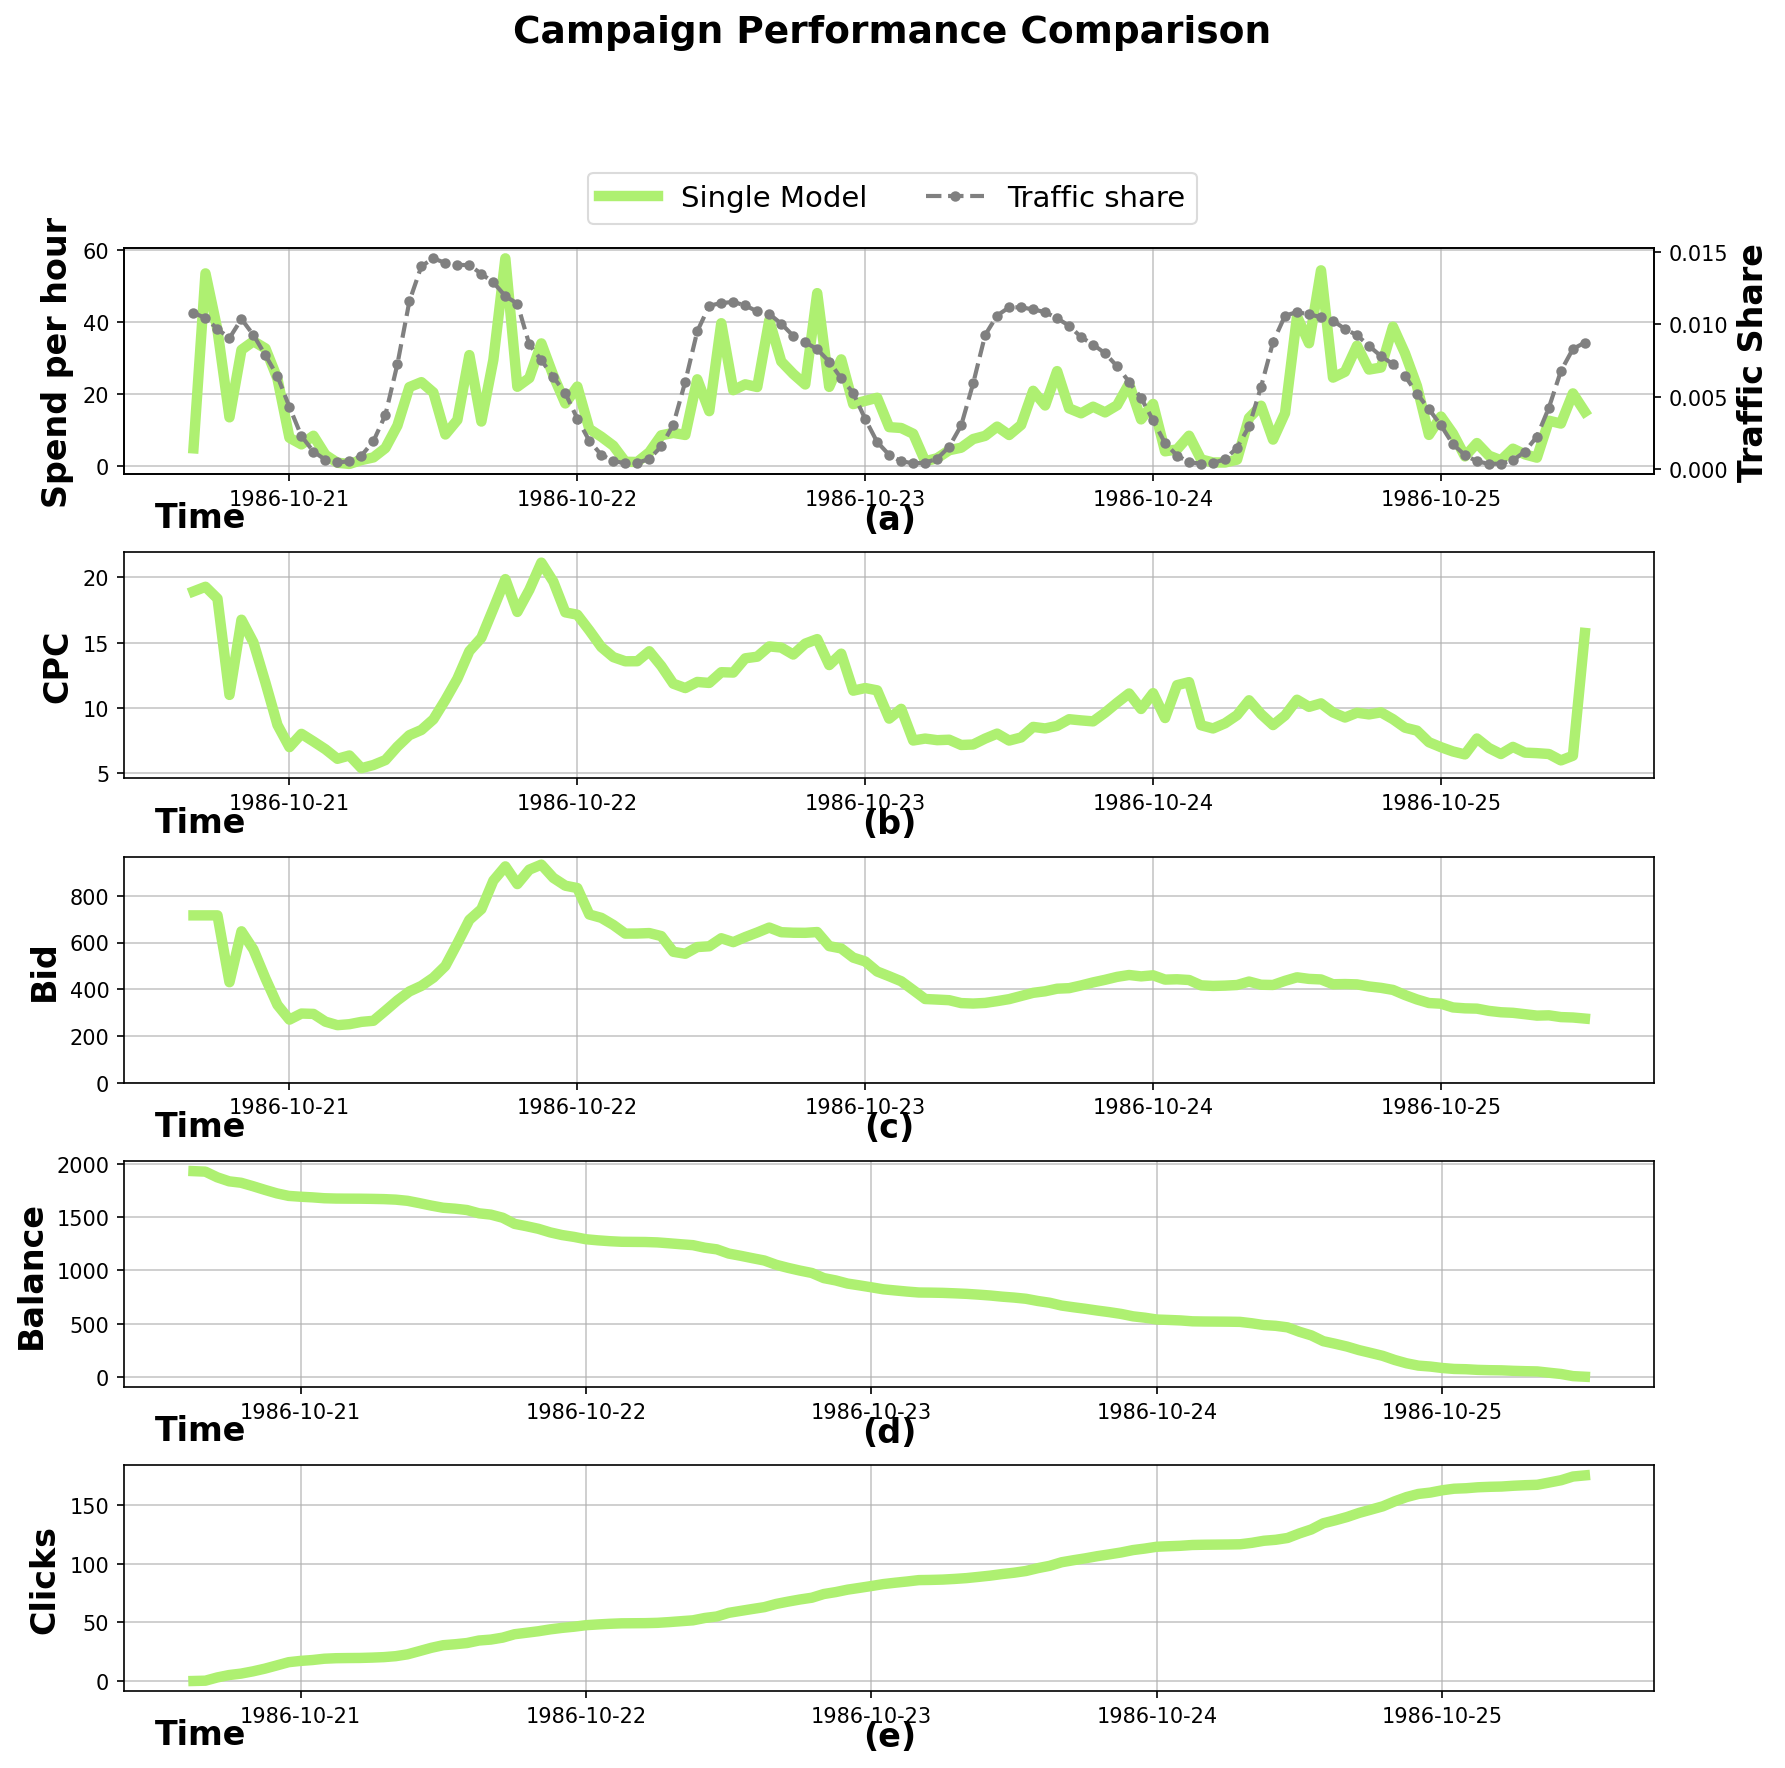

In [32]:
fig = plot_history_article(viz_data_ta_pid)

## M-PID Bidder

In [33]:
# refreshing Campaign
campaign_example = Campaign(
    item_id=campaign_data['item_id'],
    campaign_id=int(campaign_data['campaign_id']),
    loc_id=int(campaign_data["loc_id"]),
    region_id=int(campaign_data["region_id"]),
    logical_category=campaign_data["logical_category"],
    microcat_ext=int(campaign_data["microcat_ext"]),
    campaign_start=int(campaign_data["campaign_start"]),
    campaign_end=int(campaign_data["campaign_end"]),
    initial_balance=campaign_data['auction_budget'],
    balance=campaign_data['auction_budget'],
    curr_time=int(campaign_data["campaign_start"]),
    prev_time=int(campaign_data["campaign_start"]),
    prev_balance=campaign_data['auction_budget'],
)
print("Budget ", campaign_data['auction_budget']) 
print("Length hours ", (campaign_data['campaign_end'] - campaign_data['campaign_start']) // 3600)

Budget  1935.36
Length hours  120


In [34]:
simulation_history = simulate_campaign(
    campaign=campaign_example,
    bidder=MPIDBidder(),
    stats_file=campaign_stats,
    auction_mode=auction_mode,
)

In [35]:
df = simulation_history.to_data_frame()
viz_data_m_pid = data_prep_vis(df)
df.head(10)

,curr_time,curr_timestamp,campaign_start_time,campaign_end_time,campaign_id,balance,initial_balance,clicks,contacts,bid,loc_id,region_id,logical_category,microcat_ext,prev_timestamp,desired_clicks,desired_time,spend_history,clicks_history,tr_share,tr_share_cs,price_bin,cpc
0,1986-10-20 16:00:00,530197200,530196847,530628847,82325409,1935.297799,1935.36,0.156542,0.004203,14.8,640860,640310,2.5,3807,530193600,0,0,0.062201,0.156542,0.010787,0.010787,14.779531,0.397346
1,1986-10-20 17:00:00,530200800,530196847,530628847,82325409,1935.047044,1935.36,1.219625,0.035547,8.0,640860,640310,2.5,3807,530197200,0,0,0.250755,1.063083,0.010435,0.021222,11.405352,0.235875
2,1986-10-20 18:00:00,530204400,530196847,530628847,82325409,1934.383801,1935.36,2.344697,0.064637,22.8,640860,640310,2.5,3807,530200800,0,0,0.663242,1.125071,0.009674,0.030896,17.149703,0.589511
3,1986-10-20 19:00:00,530208000,530196847,530628847,82325409,1933.999132,1935.36,2.834853,0.077290,30.4,640860,640310,2.5,3807,530204400,0,0,0.384669,0.490157,0.009053,0.039949,18.727586,0.784788
4,1986-10-20 20:00:00,530211600,530196847,530628847,82325409,1932.752990,1935.36,4.093517,0.110084,38.0,640860,640310,2.5,3807,530208000,0,0,1.246142,1.258664,0.010364,0.050313,19.951487,0.990051
5,1986-10-20 21:00:00,530215200,530196847,530628847,82325409,1930.150618,1935.36,6.255772,0.167153,45.6,640860,640310,2.5,3807,530211600,0,0,2.602372,2.162254,0.009260,0.059573,20.951487,1.203546
6,1986-10-20 22:00:00,530218800,530196847,530628847,82325409,1926.483714,1935.36,8.830656,0.236080,53.2,640860,640310,2.5,3807,530215200,0,0,3.666905,2.574884,0.007862,0.067435,21.796975,1.424105
7,1986-10-20 23:00:00,530222400,530196847,530628847,82325409,1922.530400,1935.36,11.327358,0.301101,60.8,640860,640310,2.5,3807,530218800,0,0,3.953314,2.496703,0.006424,0.073859,22.529370,1.583414
8,1986-10-21 00:00:00,530226000,530196847,530628847,82325409,1920.684324,1935.36,12.370383,0.328091,68.4,640860,640310,2.5,3807,530222400,0,0,1.846076,1.043024,0.004303,0.078162,23.175388,1.769926
9,1986-10-21 01:00:00,530229600,530196847,530628847,82325409,1919.217937,1935.36,13.082104,0.347385,76.0,640860,640310,2.5,3807,530226000,0,0,1.466388,0.711721,0.002299,0.080461,23.753271,2.060340


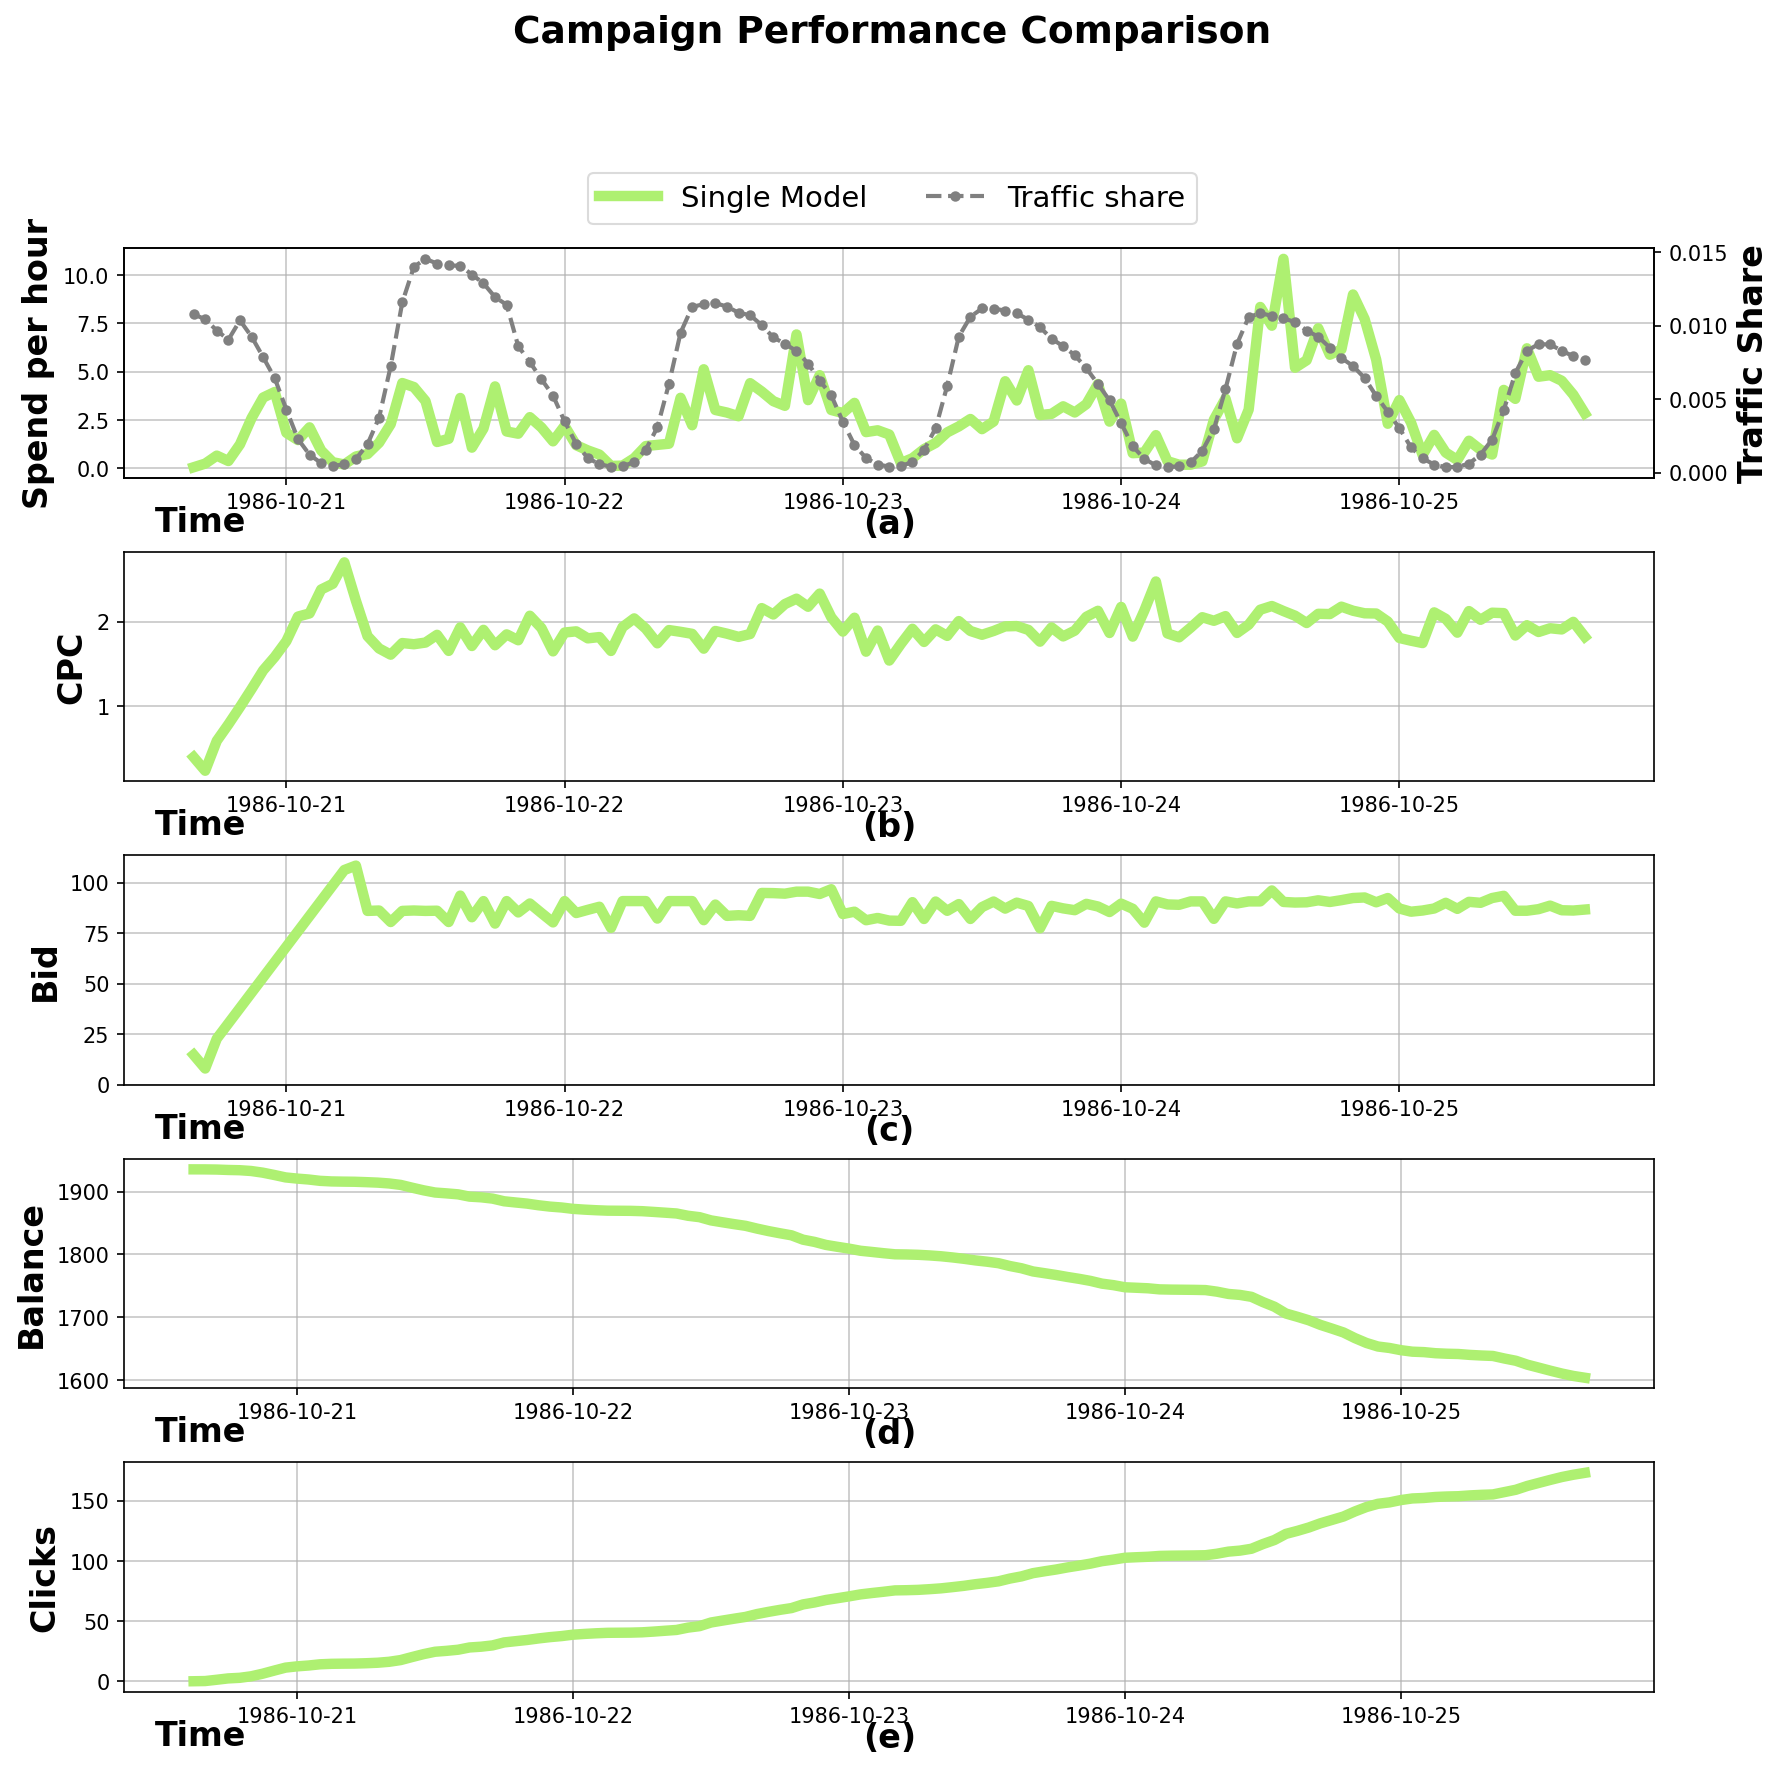

In [36]:
fig = plot_history_article(viz_data_m_pid)

In [37]:
# refreshing Campaign
campaign_example = Campaign(
    item_id=campaign_data['item_id'],
    campaign_id=int(campaign_data['campaign_id']),
    loc_id=int(campaign_data["loc_id"]),
    region_id=int(campaign_data["region_id"]),
    logical_category=campaign_data["logical_category"],
    microcat_ext=int(campaign_data["microcat_ext"]),
    campaign_start=int(campaign_data["campaign_start"]),
    campaign_end=int(campaign_data["campaign_end"]),
    initial_balance=campaign_data['auction_budget'],
    balance=campaign_data['auction_budget'],
    curr_time=int(campaign_data["campaign_start"]),
    prev_time=int(campaign_data["campaign_start"]),
    prev_balance=campaign_data['auction_budget'],
)
print("Budget ", campaign_data['auction_budget']) 
print("Length hours ", (campaign_data['campaign_end'] - campaign_data['campaign_start']) // 3600)

Budget  1935.36
Length hours  120


In [38]:
simulation_history = simulate_campaign(
    campaign=campaign_example,
    bidder=BROI(),
    stats_file=campaign_stats,
    auction_mode=auction_mode,
)

In [39]:
df = simulation_history.to_data_frame()
viz_data_broi = data_prep_vis(df)
df.head(10)

,curr_time,curr_timestamp,campaign_start_time,campaign_end_time,campaign_id,balance,initial_balance,clicks,contacts,bid,loc_id,region_id,logical_category,microcat_ext,prev_timestamp,desired_clicks,desired_time,spend_history,clicks_history,tr_share,tr_share_cs,price_bin,cpc
0,1986-10-20 16:00:00,530197200,530196847,530628847,82325409,1935.360000,1935.36,0.000000,0.000000,6.191736,640860,640310,2.5,3807,530193600,0,0,0.000000,0.000000,0.010787,0.010787,10.0,0.000000
1,1986-10-20 17:00:00,530200800,530196847,530628847,82325409,1935.214611,1935.36,0.759894,0.023481,6.191736,640860,640310,2.5,3807,530197200,0,0,0.145389,0.759894,0.010435,0.021222,10.0,0.191327
2,1986-10-20 18:00:00,530204400,530196847,530628847,82325409,1935.214611,1935.36,0.759894,0.023481,6.191736,640860,640310,2.5,3807,530200800,0,0,0.000000,0.000000,0.009674,0.030896,10.0,0.000000
3,1986-10-20 19:00:00,530208000,530196847,530628847,82325409,1935.183189,1935.36,0.953610,0.028556,6.191736,640860,640310,2.5,3807,530204400,0,0,0.031422,0.193716,0.009053,0.039949,10.0,0.162208
4,1986-10-20 20:00:00,530211600,530196847,530628847,82325409,1935.135163,1935.36,1.242516,0.036312,6.191736,640860,640310,2.5,3807,530208000,0,0,0.048026,0.288906,0.010364,0.050313,10.0,0.166234
5,1986-10-20 21:00:00,530215200,530196847,530628847,82325409,1934.943990,1935.36,2.366363,0.067188,6.191736,640860,640310,2.5,3807,530211600,0,0,0.191174,1.123847,0.009260,0.059573,10.0,0.170106
6,1986-10-20 22:00:00,530218800,530196847,530628847,82325409,1934.758625,1935.36,3.416536,0.097125,6.191736,640860,640310,2.5,3807,530215200,0,0,0.185364,1.050173,0.007862,0.067435,10.0,0.176509
7,1986-10-20 23:00:00,530222400,530196847,530628847,82325409,1934.633997,1935.36,4.156438,0.117254,6.191736,640860,640310,2.5,3807,530218800,0,0,0.124628,0.739902,0.006424,0.073859,10.0,0.168439
8,1986-10-21 00:00:00,530226000,530196847,530628847,82325409,1934.565580,1935.36,4.572057,0.128303,6.191736,640860,640310,2.5,3807,530222400,0,0,0.068417,0.415619,0.004303,0.078162,10.0,0.164614
9,1986-10-21 01:00:00,530229600,530196847,530628847,82325409,1934.523245,1935.36,4.806286,0.135141,6.191736,640860,640310,2.5,3807,530226000,0,0,0.042336,0.234229,0.002299,0.080461,10.0,0.180744


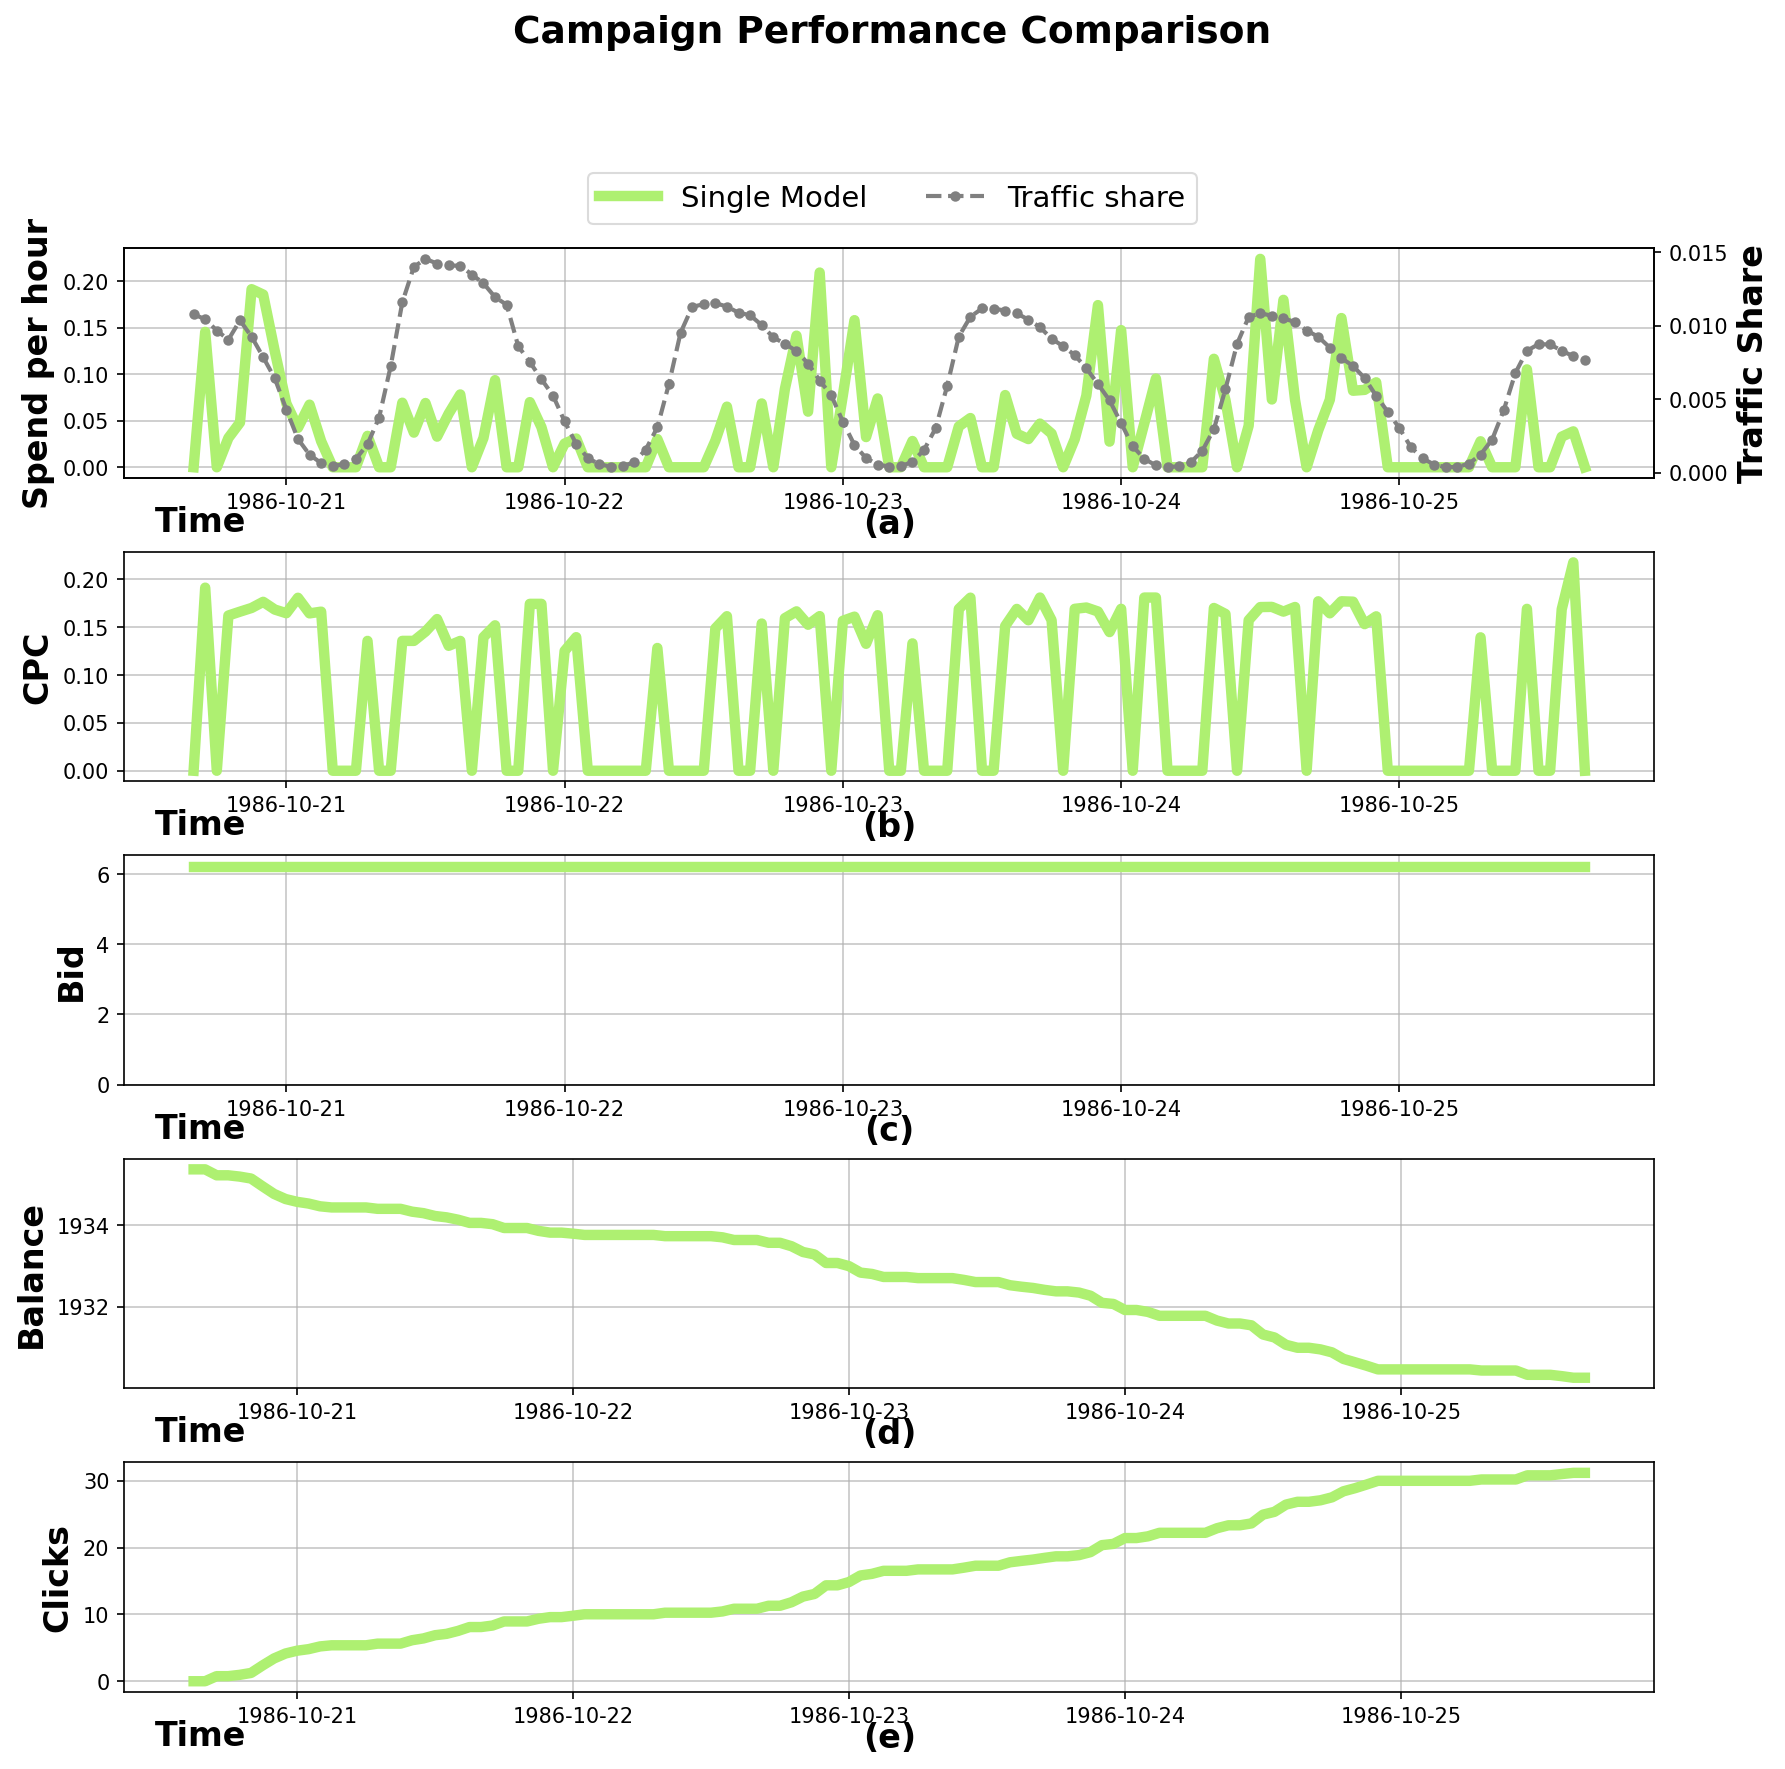

In [40]:
fig = plot_history_article(viz_data_broi)

## You may also compare the performance of all the baselines:

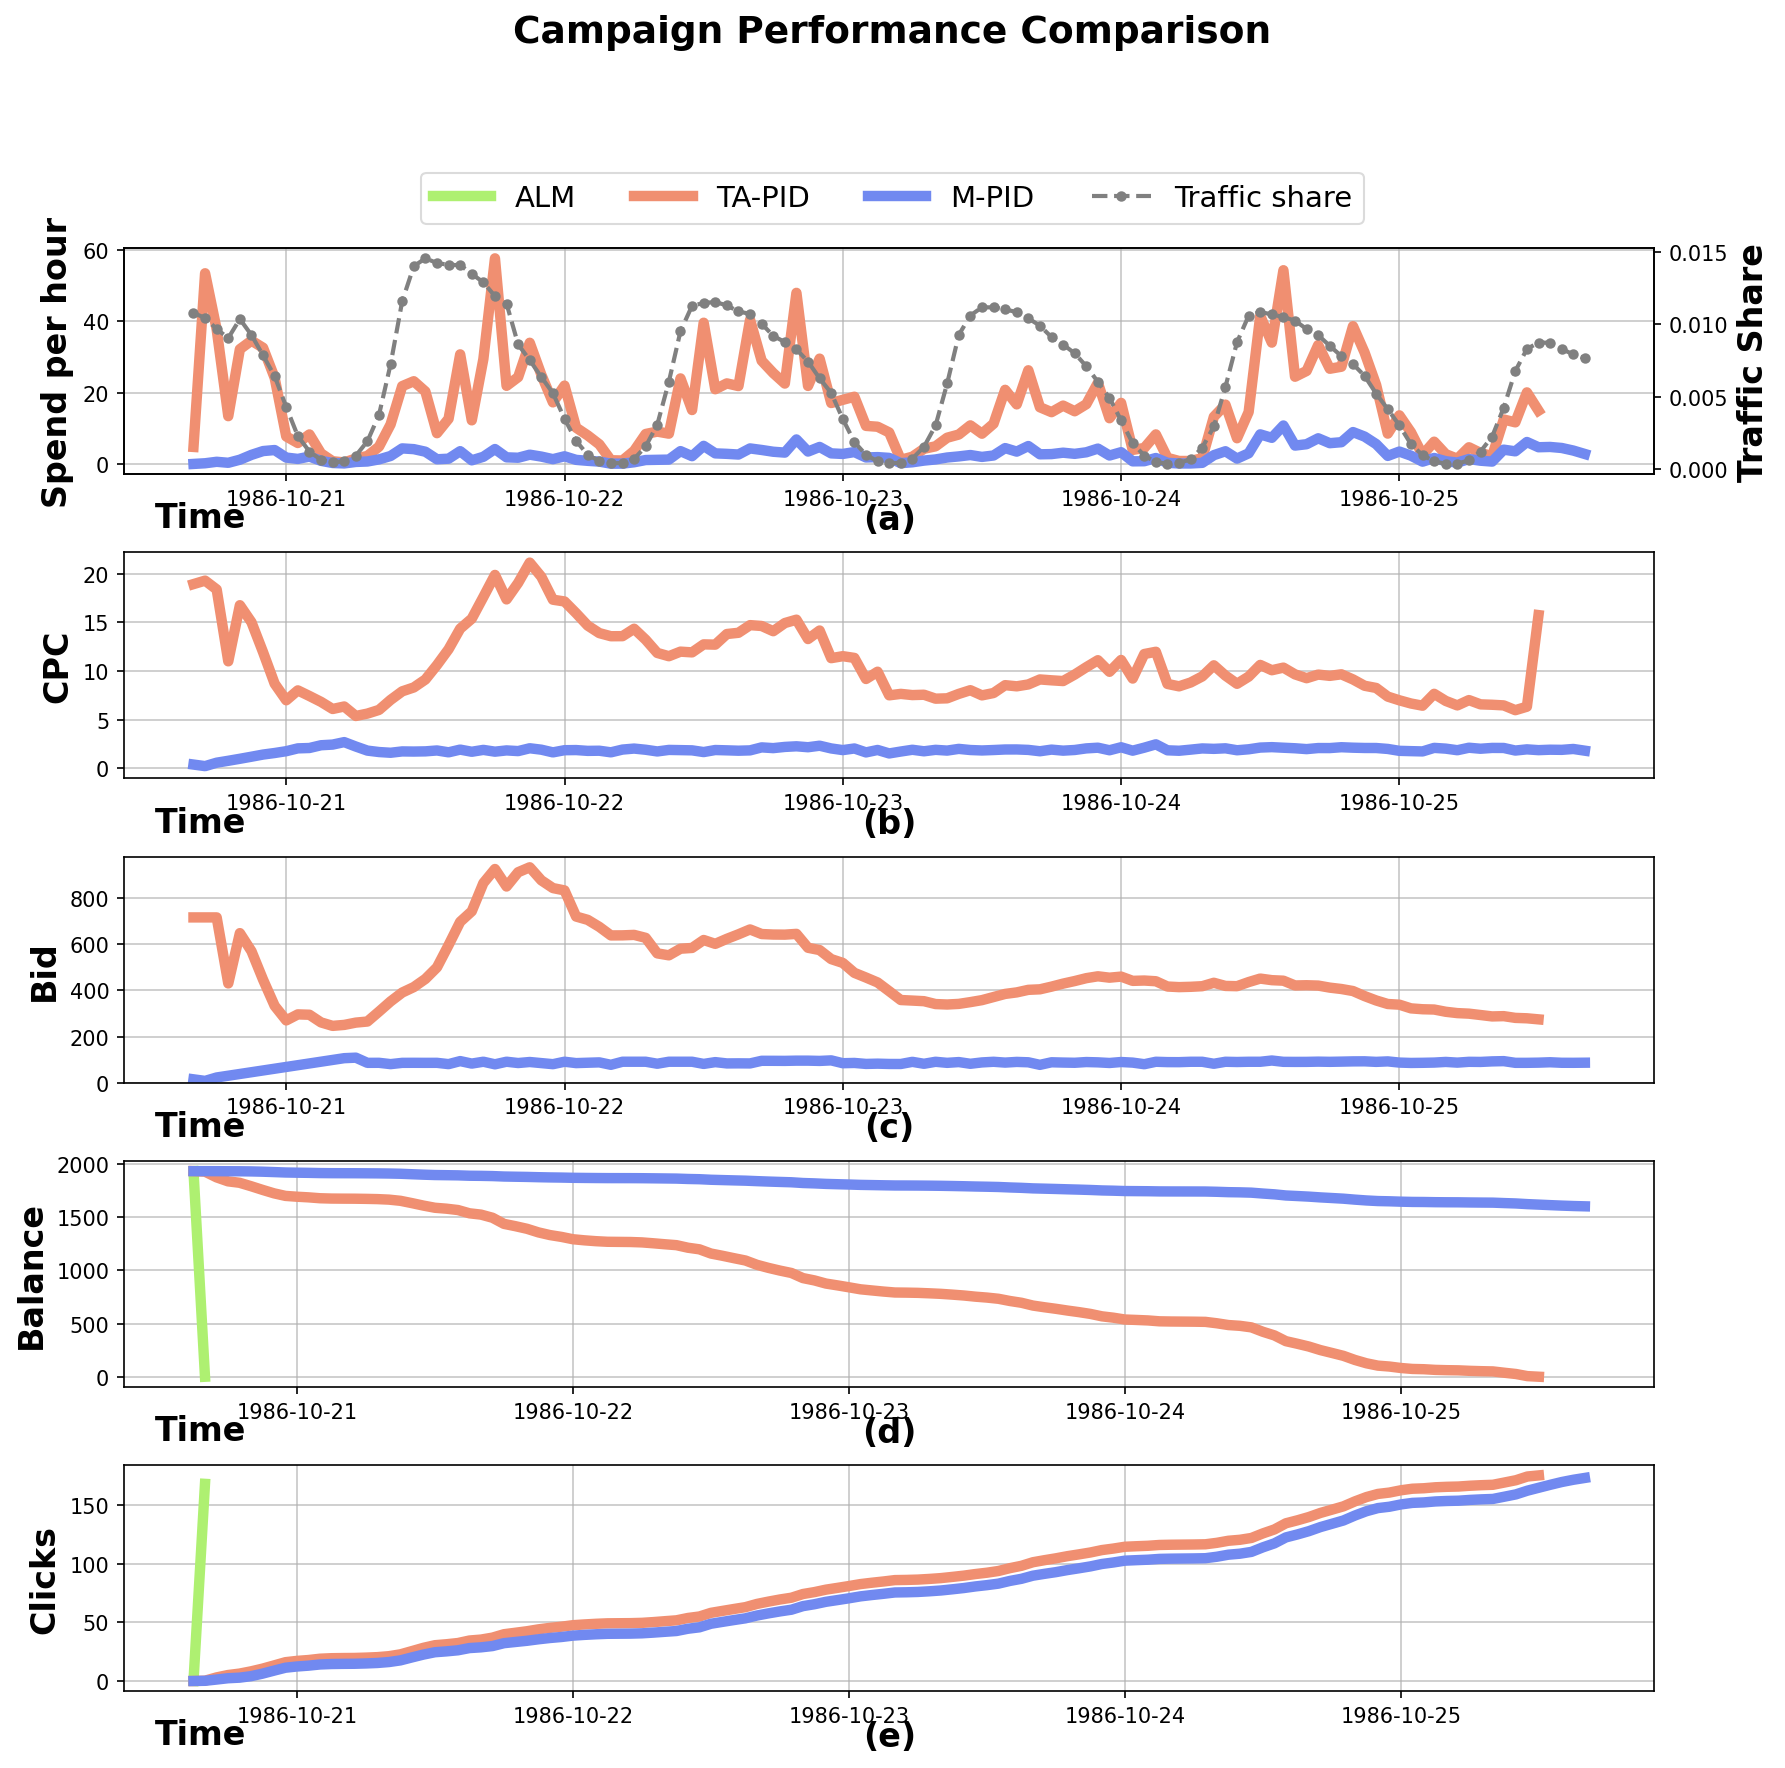

In [41]:
f = plot_history_article([viz_data_linear, viz_data_ta_pid, viz_data_m_pid], single_plot=False)

# Metrics

In [42]:
best_metrics = np.ones((3, 3)) * 100000

In [43]:
best_metrics

array([[100000., 100000., 100000.],
       [100000., 100000., 100000.],
       [100000., 100000., 100000.]])

### Mean 

## Linear Bidder

In [48]:
def objective_linear(trial, metric='RMSE_T', auction_mode='FPA'):
    coef = trial.suggest_float('coef', 0.001, 0.999, log=True) # Cold start coefficient
    lower_clip = trial.suggest_int('lower_clip', 1, 20, log=True)
    upper_clip = trial.suggest_int('upper_clip', 1, 20, log=True)
    factor = trial.suggest_float('factor', 1.1, 10.0, log=True)
   
    res = autobidder_check(
        bidder=LinearBidder,
        params={
            "input_campaigns": campaigns_path,
            "input_stats": stats_path,
            "cold_start_coef": coef,
            "lower_clip": lower_clip,
            "upper_clip": upper_clip,
            "factor": factor # slope
        },
        auction_mode=auction_mode,
    )
    print(f"CPC_REL: {res['score'][0]}, rmse: {res['score'][1]}, SCR: {res['score'][2]}")
    if metric == 'RMSE_T':
        best_metrics[0, 0] = min(best_metrics[0, 0], res['score'][1])
        return res['score'][1] 
    elif metric == 'CPC_REL':
        best_metrics[0, 1] = min(best_metrics[0, 1], res['score'][0])
      
        return res['score'][0] 
    elif metric == 'MCR':
        best_metrics[0, 2] = max(best_metrics[0, 2], res['score'][2])
        return res['score'][2] 

    
def opt_search_linear(n_trials=100, metric='RMSE_T', auction_mode='FPA'):
    # Create pruner
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=10,
        interval_steps=1
    )

    # Create study with pruner
    study = optuna.create_study(
        direction='maximize' if (metric == 'MCR') else 'minimize',
        pruner=pruner
    )

    # Optimization
    study.optimize(
        partial(objective_linear, metric=metric, auction_mode=auction_mode),
        n_trials=n_trials,
        catch=(Exception,)
    )

    print('Best trial:')
    trial = study.best_trial
    print(f'  Value: {trial.value}')
    print('  Params: ')
    dict_path = f'best_params/linear_{metric.lower()}_{auction_mode}.pkl'
    params_dict = dict()
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
        params_dict[key] = value
    # save the best params to the file
    with open(dict_path, 'wb') as f:
        pickle.dump(params_dict, f)
    return study

In [49]:
n = 10
metric = 'RMSE_T' # for Mean Click Ratio use 'MCR'
study_linear = opt_search_linear(n, metric, auction_mode)

[I 2025-01-29 21:30:58,864] A new study created in memory with name: no-name-a1022910-ec2d-4cde-a93d-1478a912204c


[I 2025-01-29 21:30:59,141] Trial 0 finished with value: 1.209098047947529 and parameters: {'coef': 0.037463724996278945, 'lower_clip': 1, 'upper_clip': 3, 'factor': 1.9399491192903695}. Best is trial 0 with value: 1.209098047947529.


CPC_REL: 20.56607558248014, rmse: 1.209098047947529, SCR: 26.517229980714234


[I 2025-01-29 21:30:59,367] Trial 1 finished with value: 1.5236749990610512 and parameters: {'coef': 0.01231218368407193, 'lower_clip': 8, 'upper_clip': 2, 'factor': 1.4037950048165757}. Best is trial 0 with value: 1.209098047947529.


CPC_REL: 20.283006663835636, rmse: 1.5236749990610512, SCR: 25.392154546238004


[I 2025-01-29 21:30:59,602] Trial 2 finished with value: 1.2160198983303219 and parameters: {'coef': 0.03366385555410373, 'lower_clip': 18, 'upper_clip': 10, 'factor': 1.2474465106743673}. Best is trial 0 with value: 1.209098047947529.


CPC_REL: 20.364696689182892, rmse: 1.2160198983303219, SCR: 25.70583961527899


[I 2025-01-29 21:30:59,858] Trial 3 finished with value: 1.6030523434604764 and parameters: {'coef': 0.012819656124451297, 'lower_clip': 2, 'upper_clip': 1, 'factor': 5.212796053559289}. Best is trial 0 with value: 1.209098047947529.


CPC_REL: 19.222880466587778, rmse: 1.6030523434604764, SCR: 25.81236897147984


[I 2025-01-29 21:31:00,103] Trial 4 finished with value: 1.1762404364882983 and parameters: {'coef': 0.10424302186148014, 'lower_clip': 1, 'upper_clip': 3, 'factor': 1.3595063761524675}. Best is trial 4 with value: 1.1762404364882983.


CPC_REL: 21.09027031028151, rmse: 1.1762404364882983, SCR: 27.163157894236903


[I 2025-01-29 21:31:00,349] Trial 5 finished with value: 2.9161497377852834 and parameters: {'coef': 0.0010628788152795671, 'lower_clip': 2, 'upper_clip': 1, 'factor': 3.1792781429706767}. Best is trial 4 with value: 1.1762404364882983.


CPC_REL: 12.75935442349487, rmse: 2.9161497377852834, SCR: 21.91791914101666


[I 2025-01-29 21:31:00,579] Trial 6 finished with value: 1.2941468090739214 and parameters: {'coef': 0.020729460411813484, 'lower_clip': 6, 'upper_clip': 3, 'factor': 4.453090250810897}. Best is trial 4 with value: 1.1762404364882983.


CPC_REL: 21.29722046982638, rmse: 1.2941468090739214, SCR: 25.139104105460405


[I 2025-01-29 21:31:00,810] Trial 7 finished with value: 1.5058734668288978 and parameters: {'coef': 0.014393552475281632, 'lower_clip': 9, 'upper_clip': 5, 'factor': 1.4864241789797283}. Best is trial 4 with value: 1.1762404364882983.


CPC_REL: 19.594203201823056, rmse: 1.5058734668288978, SCR: 25.72542109922653


[I 2025-01-29 21:31:01,050] Trial 8 finished with value: 2.0420091046874838 and parameters: {'coef': 0.0018891692634148188, 'lower_clip': 11, 'upper_clip': 6, 'factor': 1.357373273639141}. Best is trial 4 with value: 1.1762404364882983.


CPC_REL: 15.03338860704061, rmse: 2.0420091046874838, SCR: 21.562449406631945


[I 2025-01-29 21:31:01,277] Trial 9 finished with value: 2.1849920420862827 and parameters: {'coef': 0.044849842140173075, 'lower_clip': 16, 'upper_clip': 19, 'factor': 8.43630588215459}. Best is trial 4 with value: 1.1762404364882983.


CPC_REL: 16.971788937572722, rmse: 2.1849920420862827, SCR: 26.39472837034317
Best trial:
  Value: 1.1762404364882983
  Params: 
    coef: 0.10424302186148014
    lower_clip: 1
    upper_clip: 3
    factor: 1.3595063761524675


In [50]:
n = 10
metric = 'CPC_REL' # for Mean Click Ratio use 'MCR'
study_linear = opt_search_linear(n, metric, auction_mode)

[I 2025-01-29 21:31:03,649] A new study created in memory with name: no-name-0e29fe2e-22ca-4305-8526-5bb3483573a2


[I 2025-01-29 21:31:03,882] Trial 0 finished with value: 21.73792944073969 and parameters: {'coef': 0.22622312198754235, 'lower_clip': 15, 'upper_clip': 3, 'factor': 4.524402135095971}. Best is trial 0 with value: 21.73792944073969.


CPC_REL: 21.73792944073969, rmse: 1.1753247207165765, SCR: 26.441484538940774


[I 2025-01-29 21:31:04,108] Trial 1 finished with value: 19.881351121963156 and parameters: {'coef': 0.050190637477723156, 'lower_clip': 7, 'upper_clip': 2, 'factor': 8.53199836343299}. Best is trial 1 with value: 19.881351121963156.


CPC_REL: 19.881351121963156, rmse: 1.3551910647726135, SCR: 27.14672362863209


[I 2025-01-29 21:31:04,348] Trial 2 finished with value: 16.145334851422387 and parameters: {'coef': 0.16171959870444108, 'lower_clip': 1, 'upper_clip': 18, 'factor': 7.718393604730198}. Best is trial 2 with value: 16.145334851422387.


CPC_REL: 16.145334851422387, rmse: 2.103268470145678, SCR: 28.176847453814972


[I 2025-01-29 21:31:04,594] Trial 3 finished with value: 20.724011355911937 and parameters: {'coef': 0.9632901414125765, 'lower_clip': 4, 'upper_clip': 7, 'factor': 2.342994959185247}. Best is trial 2 with value: 16.145334851422387.


CPC_REL: 20.724011355911937, rmse: 0.865149452065272, SCR: 27.000741983778145


[I 2025-01-29 21:31:04,813] Trial 4 finished with value: 23.590810937713126 and parameters: {'coef': 0.4027814439816596, 'lower_clip': 1, 'upper_clip': 1, 'factor': 4.609354761490406}. Best is trial 2 with value: 16.145334851422387.


CPC_REL: 23.590810937713126, rmse: 1.1310481100553524, SCR: 25.94907007405193


[I 2025-01-29 21:31:05,036] Trial 5 finished with value: 21.771789747942844 and parameters: {'coef': 0.28202461902101233, 'lower_clip': 1, 'upper_clip': 11, 'factor': 2.854551131306378}. Best is trial 2 with value: 16.145334851422387.


CPC_REL: 21.771789747942844, rmse: 1.1430722151651203, SCR: 26.688105527835866


[I 2025-01-29 21:31:05,266] Trial 6 finished with value: 20.710510346033587 and parameters: {'coef': 0.007663273352612406, 'lower_clip': 11, 'upper_clip': 17, 'factor': 5.794197168845864}. Best is trial 2 with value: 16.145334851422387.


CPC_REL: 20.710510346033587, rmse: 1.2442643947890086, SCR: 25.474851859930865


[I 2025-01-29 21:31:05,498] Trial 7 finished with value: 20.81317410311796 and parameters: {'coef': 0.11194316017001506, 'lower_clip': 10, 'upper_clip': 7, 'factor': 1.7046457494249996}. Best is trial 2 with value: 16.145334851422387.


CPC_REL: 20.81317410311796, rmse: 1.0494444527924662, SCR: 26.546618182665934


[I 2025-01-29 21:31:05,717] Trial 8 finished with value: 21.982973231743287 and parameters: {'coef': 0.017341574314408154, 'lower_clip': 10, 'upper_clip': 3, 'factor': 2.8957073748955895}. Best is trial 2 with value: 16.145334851422387.


CPC_REL: 21.982973231743287, rmse: 1.0746458580469618, SCR: 25.3469288095666


[I 2025-01-29 21:31:05,939] Trial 9 finished with value: 17.37398025512829 and parameters: {'coef': 0.13251099635104727, 'lower_clip': 5, 'upper_clip': 18, 'factor': 8.18770663485892}. Best is trial 2 with value: 16.145334851422387.


CPC_REL: 17.37398025512829, rmse: 1.9373075859161706, SCR: 27.574199898056882
Best trial:
  Value: 16.145334851422387
  Params: 
    coef: 0.16171959870444108
    lower_clip: 1
    upper_clip: 18
    factor: 7.718393604730198


In [51]:
n = 10
metric = 'MCR' # for Mean Click Ratio use 'MCR'
study_linear = opt_search_linear(n, metric, auction_mode)

[I 2025-01-29 21:31:07,919] A new study created in memory with name: no-name-baef217f-c21a-47a8-8e0b-03e2b3e28772


[I 2025-01-29 21:31:08,138] Trial 0 finished with value: 22.815102956094982 and parameters: {'coef': 0.0019596716429195983, 'lower_clip': 2, 'upper_clip': 5, 'factor': 3.255749075394912}. Best is trial 0 with value: 22.815102956094982.


CPC_REL: 21.64577015833758, rmse: 1.7672559879531968, SCR: 22.815102956094982


[I 2025-01-29 21:31:08,368] Trial 1 finished with value: 26.583057489678172 and parameters: {'coef': 0.46902512755377196, 'lower_clip': 4, 'upper_clip': 1, 'factor': 1.3641066189533264}. Best is trial 1 with value: 26.583057489678172.


CPC_REL: 20.70395331657091, rmse: 1.0058374272777884, SCR: 26.583057489678172


[I 2025-01-29 21:31:08,601] Trial 2 finished with value: 26.615441667476073 and parameters: {'coef': 0.02719100302247348, 'lower_clip': 11, 'upper_clip': 16, 'factor': 9.834631710104205}. Best is trial 2 with value: 26.615441667476073.


CPC_REL: 15.486381182248463, rmse: 2.503946714948477, SCR: 26.615441667476073


[I 2025-01-29 21:31:08,848] Trial 3 finished with value: 22.937355710330866 and parameters: {'coef': 0.004243571694615076, 'lower_clip': 1, 'upper_clip': 3, 'factor': 1.2466265604023459}. Best is trial 2 with value: 26.615441667476073.


CPC_REL: 17.073550413002202, rmse: 1.6937309909560319, SCR: 22.937355710330866


[I 2025-01-29 21:31:09,081] Trial 4 finished with value: 26.118571643861678 and parameters: {'coef': 0.03313025680164253, 'lower_clip': 10, 'upper_clip': 2, 'factor': 8.891538172583074}. Best is trial 2 with value: 26.615441667476073.


CPC_REL: 16.98555934869131, rmse: 2.3418159676964057, SCR: 26.118571643861678


[I 2025-01-29 21:31:09,304] Trial 5 finished with value: 26.279453691932463 and parameters: {'coef': 0.10234258417126262, 'lower_clip': 5, 'upper_clip': 11, 'factor': 4.478368445595736}. Best is trial 2 with value: 26.615441667476073.


CPC_REL: 21.83159263802381, rmse: 1.1625966995026242, SCR: 26.279453691932463


[I 2025-01-29 21:31:09,526] Trial 6 finished with value: 23.09155980196015 and parameters: {'coef': 0.001203202625933916, 'lower_clip': 1, 'upper_clip': 2, 'factor': 8.909384246324267}. Best is trial 2 with value: 26.615441667476073.


CPC_REL: 17.8421760340765, rmse: 2.096876134145483, SCR: 23.09155980196015


[I 2025-01-29 21:31:09,765] Trial 7 finished with value: 26.85956640644786 and parameters: {'coef': 0.7332962881876194, 'lower_clip': 20, 'upper_clip': 3, 'factor': 1.165455899179195}. Best is trial 7 with value: 26.85956640644786.


CPC_REL: 22.88896557415341, rmse: 0.8952407001997215, SCR: 26.85956640644786


[I 2025-01-29 21:31:09,977] Trial 8 finished with value: 24.341550223975894 and parameters: {'coef': 0.005874664383380026, 'lower_clip': 7, 'upper_clip': 2, 'factor': 1.9878680099168688}. Best is trial 7 with value: 26.85956640644786.


CPC_REL: 20.054043467544687, rmse: 1.8554589972602098, SCR: 24.341550223975894


[I 2025-01-29 21:31:10,192] Trial 9 finished with value: 26.967005026274286 and parameters: {'coef': 0.05498724277017059, 'lower_clip': 5, 'upper_clip': 4, 'factor': 6.503288072525371}. Best is trial 9 with value: 26.967005026274286.


CPC_REL: 18.863295255275407, rmse: 1.6784824022986664, SCR: 26.967005026274286
Best trial:
  Value: 26.967005026274286
  Params: 
    coef: 0.05498724277017059
    lower_clip: 5
    upper_clip: 4
    factor: 6.503288072525371


## TA-PID Bidder

In [52]:
def objective_tapid(trial, metric='RMSE_T', auction_mode='FPA'):
    k_p1 = trial.suggest_float('k_p1', 1e-4, 1, log=True)
    k_i1 = trial.suggest_float('k_i1', 1e-4, 1, log=True)
    k_d1 = trial.suggest_float('k_d1', 1e-4, 1, log=True)
    coef = trial.suggest_float('coef', 0.1, 0.9, log=True) # Cold start coefficient
    k_dict = {
        'k_p': k_p1,
        'k_i': k_i1,
        'k_d': k_d1
    }
   
    res = autobidder_check(
        bidder=TAPIDBidder,
        params={
            "input_campaigns": campaigns_path,
            "input_stats": stats_path,
            "k_dict": k_dict, 
            'cold_start_coef': coef,
        },
        auction_mode=auction_mode,
    )
    print(f"CPC_REL: {res['score'][0]}, rmse: {res['score'][1]}, SCR: {res['score'][2]}")
    if metric == 'RMSE_T':
        best_metrics[0, 0] = min(best_metrics[0, 0], res['score'][1])
        return res['score'][1] 
    elif metric == 'CPC_REL':
        best_metrics[0, 1] = min(best_metrics[0, 1], res['score'][0])
        print(f'PROBLEMS???{abs(1 - res["score"][0])}')
        return res['score'][0] 
    elif metric == 'MCR':
        best_metrics[0, 2] = max(best_metrics[0, 2], res['score'][2])
        return res['score'][2] 

def opt_search_tapid(n_trials, metric, auction_mode='FPA'):
    # if metric == 'RMSE_T':
    study = optuna.create_study(
        direction='maximize' if metric == 'MCR' else 'minimize'
    )
    # elif metric == 'MCR':
    #     study = optuna.create_study(direction='maximize')
    study.optimize(partial(objective_tapid, metric=metric, auction_mode=auction_mode), n_trials=n_trials)

    print('Best trial:')
    trial = study.best_trial
    print(f'  Value: {trial.value}')
    print('  Params: ')
    dict_path = f'best_params/ta_pid_{metric.lower()}_{auction_mode}.pkl'
    params_dict = dict()
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
        params_dict[key] = value
    # save the best params to the file
    with open(dict_path, 'wb') as f:
        pickle.dump(params_dict, f)
    return study

In [53]:
n = 10
metric = 'RMSE_T' # for Mean Click Ratio use 'MCR'
study_ta_pid = opt_search_tapid(n, metric, auction_mode)

[I 2025-01-29 21:31:11,815] A new study created in memory with name: no-name-e0d5729e-b92f-44a6-8e3f-0d9dc78ca7da


[I 2025-01-29 21:31:12,011] Trial 0 finished with value: 1.5626053827513326 and parameters: {'k_p1': 0.004548395331717077, 'k_i1': 0.014935790119116095, 'k_d1': 0.0002776217131347194, 'coef': 0.7222897704849105}. Best is trial 0 with value: 1.5626053827513326.
[I 2025-01-29 21:31:12,201] Trial 1 finished with value: 2.01682479587834 and parameters: {'k_p1': 0.000297734888587274, 'k_i1': 0.416498688067696, 'k_d1': 0.0004655644632926983, 'coef': 0.11891597072099908}. Best is trial 0 with value: 1.5626053827513326.


CPC_REL: 18.85974916185529, rmse: 1.5626053827513326, SCR: 27.308665844606868
CPC_REL: 4.043181104726454, rmse: 2.01682479587834, SCR: 13.041058843129521


[I 2025-01-29 21:31:12,397] Trial 2 finished with value: 1.0577166710715573 and parameters: {'k_p1': 0.22337281651076862, 'k_i1': 0.037967277037945606, 'k_d1': 0.34721946576340773, 'coef': 0.11251251279546783}. Best is trial 2 with value: 1.0577166710715573.


CPC_REL: 13.150023107453352, rmse: 1.0577166710715573, SCR: 24.308968543851403


[I 2025-01-29 21:31:12,620] Trial 3 finished with value: 1.0873746847650823 and parameters: {'k_p1': 0.0074283331785933255, 'k_i1': 0.0006955868142638219, 'k_d1': 0.35108770227469294, 'coef': 0.7303546646112711}. Best is trial 2 with value: 1.0577166710715573.
[I 2025-01-29 21:31:12,806] Trial 4 finished with value: 1.3302276475921635 and parameters: {'k_p1': 0.0026153595181578706, 'k_i1': 0.00014250520565837937, 'k_d1': 0.002597477945646092, 'coef': 0.4284237316176357}. Best is trial 2 with value: 1.0577166710715573.


CPC_REL: 12.261143324390975, rmse: 1.0873746847650823, SCR: 24.607918795493
CPC_REL: 16.620983815034304, rmse: 1.3302276475921635, SCR: 27.01270394387471


[I 2025-01-29 21:31:12,995] Trial 5 finished with value: 1.0265831585482368 and parameters: {'k_p1': 0.0003518278928951109, 'k_i1': 0.00013241816047310754, 'k_d1': 0.022871593257050696, 'coef': 0.33361193176460946}. Best is trial 5 with value: 1.0265831585482368.
[I 2025-01-29 21:31:13,190] Trial 6 finished with value: 1.0873746847650823 and parameters: {'k_p1': 0.0027216873742663982, 'k_i1': 0.05288463585075414, 'k_d1': 0.3433618070444853, 'coef': 0.19830294070540688}. Best is trial 5 with value: 1.0265831585482368.


CPC_REL: 12.483820381289455, rmse: 1.0265831585482368, SCR: 24.677759323975035
CPC_REL: 12.261143324390975, rmse: 1.0873746847650823, SCR: 24.607918795493


[I 2025-01-29 21:31:13,382] Trial 7 finished with value: 4.2244736609584415 and parameters: {'k_p1': 0.12189817873311744, 'k_i1': 0.023557402784626025, 'k_d1': 0.0009984783642938803, 'coef': 0.35521270267315985}. Best is trial 5 with value: 1.0265831585482368.
[I 2025-01-29 21:31:13,566] Trial 8 finished with value: 2.447894122938879 and parameters: {'k_p1': 0.15401781310083681, 'k_i1': 0.00043770223567283194, 'k_d1': 0.0007900269522049373, 'coef': 0.27892718255021787}. Best is trial 5 with value: 1.0265831585482368.


CPC_REL: 6.009967646552737, rmse: 4.2244736609584415, SCR: 14.579810943248397
CPC_REL: 14.189693511200582, rmse: 2.447894122938879, SCR: 25.54205652181115


[I 2025-01-29 21:31:13,723] Trial 9 finished with value: 4.829513891465078 and parameters: {'k_p1': 0.01489667150093178, 'k_i1': 0.00013917273280819676, 'k_d1': 0.01129712271881204, 'coef': 0.1513301373420616}. Best is trial 5 with value: 1.0265831585482368.


CPC_REL: 18.804019387527028, rmse: 4.829513891465078, SCR: 17.06461497004329
Best trial:
  Value: 1.0265831585482368
  Params: 
    k_p1: 0.0003518278928951109
    k_i1: 0.00013241816047310754
    k_d1: 0.022871593257050696
    coef: 0.33361193176460946


In [54]:
n = 10
metric = 'CPC_REL' # for Mean Click Ratio use 'MCR'
study_ta_pid = opt_search_tapid(n, metric, auction_mode)

[I 2025-01-29 21:31:13,734] A new study created in memory with name: no-name-db04ce74-5a58-4cd3-98b6-dd183abf29cc
[I 2025-01-29 21:31:13,924] Trial 0 finished with value: 18.12257243292887 and parameters: {'k_p1': 0.0008589391358424324, 'k_i1': 0.00043855224535082455, 'k_d1': 0.0003569739180550909, 'coef': 0.4395637465135585}. Best is trial 0 with value: 18.12257243292887.


CPC_REL: 18.12257243292887, rmse: 0.8903627275891028, SCR: 25.515868631390482
PROBLEMS???17.12257243292887


[I 2025-01-29 21:31:14,107] Trial 1 finished with value: 8.787488863476216 and parameters: {'k_p1': 0.0009704590523653656, 'k_i1': 0.3863478261200584, 'k_d1': 0.0001448618020614317, 'coef': 0.5440295389765801}. Best is trial 1 with value: 8.787488863476216.


CPC_REL: 8.787488863476216, rmse: 15.546309618575407, SCR: 17.80187278698459
PROBLEMS???7.7874888634762165


[I 2025-01-29 21:31:14,283] Trial 2 finished with value: 14.276591205400258 and parameters: {'k_p1': 0.9804589017929322, 'k_i1': 0.029394945621446567, 'k_d1': 0.006596949701913238, 'coef': 0.8633180103128583}. Best is trial 1 with value: 8.787488863476216.


CPC_REL: 14.276591205400258, rmse: 3.091480653918343, SCR: 21.726093329081127
PROBLEMS???13.276591205400258


[I 2025-01-29 21:31:14,460] Trial 3 finished with value: 14.3621086137721 and parameters: {'k_p1': 0.20586496400273638, 'k_i1': 0.03573472882001849, 'k_d1': 0.0014121227346907933, 'coef': 0.4622034222779839}. Best is trial 1 with value: 8.787488863476216.


CPC_REL: 14.3621086137721, rmse: 3.103300266368218, SCR: 21.72165839405533
PROBLEMS???13.3621086137721


[I 2025-01-29 21:31:14,660] Trial 4 finished with value: 12.261143324390975 and parameters: {'k_p1': 0.0003399578902209211, 'k_i1': 0.006138982462319863, 'k_d1': 0.6761828854161438, 'coef': 0.3225037103433094}. Best is trial 1 with value: 8.787488863476216.


CPC_REL: 12.261143324390975, rmse: 1.0873746847650823, SCR: 24.607918795493
PROBLEMS???11.261143324390975


[I 2025-01-29 21:31:14,842] Trial 5 finished with value: 17.971224954856204 and parameters: {'k_p1': 0.35622126672590193, 'k_i1': 0.5730561655067473, 'k_d1': 0.1632199655582522, 'coef': 0.1717190705905697}. Best is trial 1 with value: 8.787488863476216.


CPC_REL: 17.971224954856204, rmse: 1.5041089129989837, SCR: 26.781218097600696
PROBLEMS???16.971224954856204


[I 2025-01-29 21:31:15,033] Trial 6 finished with value: 13.979560083851867 and parameters: {'k_p1': 0.2710307332298791, 'k_i1': 0.6898991936877652, 'k_d1': 0.8241824090734708, 'coef': 0.3965533215690744}. Best is trial 1 with value: 8.787488863476216.


CPC_REL: 13.979560083851867, rmse: 1.1329232917607528, SCR: 25.965717211613864
PROBLEMS???12.979560083851867


[I 2025-01-29 21:31:15,226] Trial 7 finished with value: 12.797193419469673 and parameters: {'k_p1': 0.0006279924935787242, 'k_i1': 0.00014451063226088382, 'k_d1': 0.02082940121140585, 'coef': 0.10696191049090575}. Best is trial 1 with value: 8.787488863476216.


CPC_REL: 12.797193419469673, rmse: 1.044848929164867, SCR: 24.75483898335015
PROBLEMS???11.797193419469673


[I 2025-01-29 21:31:15,386] Trial 8 finished with value: 20.387692347632154 and parameters: {'k_p1': 0.0006798302456331481, 'k_i1': 0.8542383618478767, 'k_d1': 0.04791837148033593, 'coef': 0.18546772726746927}. Best is trial 1 with value: 8.787488863476216.


CPC_REL: 20.387692347632154, rmse: 3.521220000122023, SCR: 18.99770539163956
PROBLEMS???19.387692347632154


[I 2025-01-29 21:31:15,580] Trial 9 finished with value: 15.075028063039834 and parameters: {'k_p1': 0.00043871912606773943, 'k_i1': 0.016081735251514767, 'k_d1': 0.01641413377069496, 'coef': 0.11296441637345679}. Best is trial 1 with value: 8.787488863476216.


CPC_REL: 15.075028063039834, rmse: 1.3297766189663789, SCR: 25.754580978971035
PROBLEMS???14.075028063039834
Best trial:
  Value: 8.787488863476216
  Params: 
    k_p1: 0.0009704590523653656
    k_i1: 0.3863478261200584
    k_d1: 0.0001448618020614317
    coef: 0.5440295389765801


In [55]:
n = 10
metric = 'MCR' # for Mean Click Ratio use 'MCR'
study_linear = opt_search_tapid(n, metric, auction_mode)

[I 2025-01-29 21:31:15,592] A new study created in memory with name: no-name-e78209ce-9bb0-45aa-bfc7-3249cf09983e
[I 2025-01-29 21:31:15,791] Trial 0 finished with value: 25.478367293115763 and parameters: {'k_p1': 0.022459555660714215, 'k_i1': 0.2387841548157994, 'k_d1': 0.11652432523466212, 'coef': 0.8210251295016224}. Best is trial 0 with value: 25.478367293115763.


CPC_REL: 14.205884778390484, rmse: 1.243098143056787, SCR: 25.478367293115763


[I 2025-01-29 21:31:16,005] Trial 1 finished with value: 24.903474153886794 and parameters: {'k_p1': 0.004444519473247945, 'k_i1': 0.001383347736962033, 'k_d1': 0.013079135212825015, 'coef': 0.2086994620972402}. Best is trial 0 with value: 25.478367293115763.
[I 2025-01-29 21:31:16,195] Trial 2 finished with value: 24.11582286758479 and parameters: {'k_p1': 0.002673563652287578, 'k_i1': 0.030549188099284606, 'k_d1': 0.13669330434540522, 'coef': 0.4880911102700437}. Best is trial 0 with value: 25.478367293115763.


CPC_REL: 13.073451503966194, rmse: 1.0026902947468617, SCR: 24.903474153886794
CPC_REL: 11.394933141732121, rmse: 0.9787181128039164, SCR: 24.11582286758479


[I 2025-01-29 21:31:16,389] Trial 3 finished with value: 25.480477149221464 and parameters: {'k_p1': 0.027662425206578665, 'k_i1': 0.02188513944484606, 'k_d1': 0.08852275266651148, 'coef': 0.13382104217746746}. Best is trial 3 with value: 25.480477149221464.
[I 2025-01-29 21:31:16,559] Trial 4 finished with value: 19.446455639225714 and parameters: {'k_p1': 0.005400621677976559, 'k_i1': 0.048474090941927915, 'k_d1': 0.009705960905073892, 'coef': 0.1444081212772151}. Best is trial 3 with value: 25.480477149221464.


CPC_REL: 13.429231167768851, rmse: 1.0319896658999546, SCR: 25.480477149221464
CPC_REL: 18.82405026738549, rmse: 3.623626437687675, SCR: 19.446455639225714


[I 2025-01-29 21:31:16,782] Trial 5 finished with value: 25.965717211613864 and parameters: {'k_p1': 0.0016057854366837007, 'k_i1': 0.15809775830583364, 'k_d1': 0.19418112908876195, 'coef': 0.10606087795172447}. Best is trial 5 with value: 25.965717211613864.


CPC_REL: 13.979560083851867, rmse: 1.1329232917607528, SCR: 25.965717211613864
CPC_REL: 2.626504734818292, rmse: 2.313343750830057, SCR: 11.598581271250408


[I 2025-01-29 21:31:16,984] Trial 6 finished with value: 11.598581271250408 and parameters: {'k_p1': 0.00026717613820959074, 'k_i1': 0.3571708238972045, 'k_d1': 0.00033745030482375065, 'coef': 0.3396228321263145}. Best is trial 5 with value: 25.965717211613864.
[I 2025-01-29 21:31:17,157] Trial 7 finished with value: 22.22327582164566 and parameters: {'k_p1': 0.03325805442038639, 'k_i1': 0.00046671854584258, 'k_d1': 0.011007141166957262, 'coef': 0.302755667783393}. Best is trial 5 with value: 25.965717211613864.
[I 2025-01-29 21:31:17,351] Trial 8 finished with value: 28.019473332446086 and parameters: {'k_p1': 0.00830067677592101, 'k_i1': 0.00196863439973201, 'k_d1': 0.008120408198318427, 'coef': 0.1833760463480386}. Best is trial 8 with value: 28.019473332446086.


CPC_REL: 19.250295314867017, rmse: 2.568313489151613, SCR: 22.22327582164566
CPC_REL: 16.292271517468798, rmse: 1.7598202951645439, SCR: 28.019473332446086


[I 2025-01-29 21:31:17,538] Trial 9 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.44869477133622443, 'k_i1': 0.0002798843898829832, 'k_d1': 0.3737993234889466, 'coef': 0.2684816491972325}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523


[I 2025-01-29 21:31:17,744] Trial 10 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.9463053255583873, 'k_i1': 0.00011735355137097024, 'k_d1': 0.9755716051162987, 'coef': 0.422428116360474}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523


[I 2025-01-29 21:31:17,955] Trial 11 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.9364575713760036, 'k_i1': 0.00010447050419756663, 'k_d1': 0.842961586102265, 'coef': 0.4637804341295068}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523


[I 2025-01-29 21:31:18,167] Trial 12 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.8736404005733518, 'k_i1': 0.00010547296774773315, 'k_d1': 0.8500307910640674, 'coef': 0.4752623535712266}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:18,365] Trial 13 finished with value: 23.971249467550667 and parameters: {'k_p1': 0.20918940764363328, 'k_i1': 0.0004266620899983571, 'k_d1': 0.00011904757850721258, 'coef': 0.7592177066340827}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523
CPC_REL: 10.853131977712883, rmse: 2.8460568001039093, SCR: 23.971249467550667


[I 2025-01-29 21:31:18,567] Trial 14 finished with value: 25.965717211613864 and parameters: {'k_p1': 0.16191356170764543, 'k_i1': 0.0042233823680857254, 'k_d1': 0.40183893275763244, 'coef': 0.2731025527306549}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:18,750] Trial 15 finished with value: 21.864885385389666 and parameters: {'k_p1': 0.2912081558768704, 'k_i1': 0.0004950902510660698, 'k_d1': 0.03484751864108945, 'coef': 0.366950652883782}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 13.979560083851867, rmse: 1.1329232917607528, SCR: 25.965717211613864
CPC_REL: 16.150184251213126, rmse: 3.1016611874418567, SCR: 21.864885385389666


[I 2025-01-29 21:31:18,950] Trial 16 finished with value: 19.916393859494843 and parameters: {'k_p1': 0.0761702257977779, 'k_i1': 0.00020868594877587133, 'k_d1': 0.001183649059286085, 'coef': 0.22357241437857941}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:19,136] Trial 17 finished with value: 23.6677301347824 and parameters: {'k_p1': 0.4313070202649855, 'k_i1': 0.004784319380856381, 'k_d1': 0.04464801341923158, 'coef': 0.6039664633147025}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 8.57240146693465, rmse: 3.264772026658847, SCR: 19.916393859494843
CPC_REL: 16.618792715765462, rmse: 2.6626062312262184, SCR: 23.6677301347824


[I 2025-01-29 21:31:19,345] Trial 18 finished with value: 24.95681819122145 and parameters: {'k_p1': 0.08433889533774898, 'k_i1': 0.0013572046992415287, 'k_d1': 0.37666035735036973, 'coef': 0.26363443688710586}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:19,545] Trial 19 finished with value: 24.4709452888826 and parameters: {'k_p1': 0.00012015530450769286, 'k_i1': 0.00030970953040701385, 'k_d1': 0.0017435478679316103, 'coef': 0.3854624928567906}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 13.088765542397343, rmse: 1.0594924878276877, SCR: 24.95681819122145
CPC_REL: 13.919779472345642, rmse: 0.904956747802027, SCR: 24.4709452888826


[I 2025-01-29 21:31:19,746] Trial 20 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.5342841826747368, 'k_i1': 0.008455674230064988, 'k_d1': 0.38519882339851413, 'coef': 0.626174194364925}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523
CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523


[I 2025-01-29 21:31:19,948] Trial 21 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.8592559748874478, 'k_i1': 0.00010376200032405635, 'k_d1': 0.8796262843310324, 'coef': 0.45883347844903155}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:20,151] Trial 22 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.9489680843300439, 'k_i1': 0.000156432692080628, 'k_d1': 0.9876146848812023, 'coef': 0.4147320730320441}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:20,352] Trial 23 finished with value: 25.965717211613864 and parameters: {'k_p1': 0.12381588763833976, 'k_i1': 0.0008118880200129217, 'k_d1': 0.2970493387710881, 'coef': 0.5654168932202273}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523
CPC_REL: 13.979560083851867, rmse: 1.1329232917607528, SCR: 25.965717211613864


[I 2025-01-29 21:31:20,535] Trial 24 finished with value: 23.904047300211825 and parameters: {'k_p1': 0.3521530323656635, 'k_i1': 0.00025984921669576695, 'k_d1': 0.04804611264399046, 'coef': 0.31640641197500663}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 16.33041200872725, rmse: 2.64766858252213, SCR: 23.904047300211825


[I 2025-01-29 21:31:20,742] Trial 25 finished with value: 24.607918795493 and parameters: {'k_p1': 0.05707078921588349, 'k_i1': 0.00010189369736195423, 'k_d1': 0.5872531779097026, 'coef': 0.24969284533943142}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:20,941] Trial 26 finished with value: 24.607918795493 and parameters: {'k_p1': 0.0008171636897127449, 'k_i1': 0.0007813853369690811, 'k_d1': 0.26344191508656584, 'coef': 0.7043795924255752}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 12.261143324390975, rmse: 1.0873746847650823, SCR: 24.607918795493
CPC_REL: 12.261143324390975, rmse: 1.0873746847650823, SCR: 24.607918795493


[I 2025-01-29 21:31:21,129] Trial 27 finished with value: 22.67995136864591 and parameters: {'k_p1': 0.42195596214918074, 'k_i1': 0.00022716830536367576, 'k_d1': 0.08474590207338008, 'coef': 0.17232284893943986}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 17.109714448493794, rmse: 2.7597053090741333, SCR: 22.67995136864591


[I 2025-01-29 21:31:21,335] Trial 28 finished with value: 25.032244065981914 and parameters: {'k_p1': 0.17994024977783027, 'k_i1': 0.0008071427003867547, 'k_d1': 0.6412858616805388, 'coef': 0.5238107509731006}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 12.919165724286561, rmse: 1.076976782236168, SCR: 25.032244065981914


[I 2025-01-29 21:31:21,552] Trial 29 finished with value: 24.115193377742667 and parameters: {'k_p1': 0.014558279849866997, 'k_i1': 0.0028387265201322838, 'k_d1': 0.1483158493794104, 'coef': 0.41003708605568717}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:21,744] Trial 30 finished with value: 19.34285238230722 and parameters: {'k_p1': 0.6001170077846743, 'k_i1': 0.00017851878337651073, 'k_d1': 0.022770368073808278, 'coef': 0.8974464520973215}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 11.175883185424155, rmse: 0.9786940054503114, SCR: 24.115193377742667
CPC_REL: 6.604268789626781, rmse: 4.3428353314139985, SCR: 19.34285238230722


[I 2025-01-29 21:31:21,945] Trial 31 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.8338189065553724, 'k_i1': 0.9390978311435046, 'k_d1': 0.6515061794524113, 'coef': 0.4470419534403395}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523
CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523


[I 2025-01-29 21:31:22,146] Trial 32 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.9918160694879553, 'k_i1': 0.00010392827457954226, 'k_d1': 0.9465515001831897, 'coef': 0.3488467790982325}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:22,345] Trial 33 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.26779723045290177, 'k_i1': 0.0001702940504283797, 'k_d1': 0.21926843994985157, 'coef': 0.5319797953952842}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:22,545] Trial 34 finished with value: 27.735116815991997 and parameters: {'k_p1': 0.4955242587504041, 'k_i1': 0.00042270562433987033, 'k_d1': 0.5373647374085673, 'coef': 0.6584848126114506}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523
CPC_REL: 15.834177122487779, rmse: 1.4010030420918789, SCR: 27.735116815991997


[I 2025-01-29 21:31:22,750] Trial 35 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.12171235559831366, 'k_i1': 0.0012185648629797477, 'k_d1': 0.08695397112206883, 'coef': 0.48649122347511853}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523
CPC_REL: 12.233501135816164, rmse: 1.0010542167815597, SCR: 24.845799033480166


[I 2025-01-29 21:31:22,951] Trial 36 finished with value: 24.845799033480166 and parameters: {'k_p1': 0.04421901731257941, 'k_i1': 0.0003212710662683302, 'k_d1': 0.13715632017923501, 'coef': 0.22472534055314664}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:23,147] Trial 37 finished with value: 21.734114672567248 and parameters: {'k_p1': 0.2881783844280433, 'k_i1': 0.03886867049942197, 'k_d1': 0.004980522455735965, 'coef': 0.2887382027591034}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:23,348] Trial 38 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.5990173565680529, 'k_i1': 0.01835847754299856, 'k_d1': 0.22029332461619028, 'coef': 0.32929145606363514}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 9.160073492748303, rmse: 4.159120444113653, SCR: 21.734114672567248
CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523


[I 2025-01-29 21:31:23,550] Trial 39 finished with value: 24.607918795493 and parameters: {'k_p1': 0.0021642597595224996, 'k_i1': 0.00012764462980303232, 'k_d1': 0.4634617821757049, 'coef': 0.4229695459473797}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:23,738] Trial 40 finished with value: 23.6677301347824 and parameters: {'k_p1': 0.6819222087038327, 'k_i1': 0.08213600336386236, 'k_d1': 0.07048771876689809, 'coef': 0.10259657561812367}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 12.261143324390975, rmse: 1.0873746847650823, SCR: 24.607918795493
CPC_REL: 16.618792715765462, rmse: 2.6626062312262184, SCR: 23.6677301347824


[I 2025-01-29 21:31:23,965] Trial 41 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.4199310400325515, 'k_i1': 0.007860185022737333, 'k_d1': 0.28328816921549826, 'coef': 0.6179647778760042}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523


[I 2025-01-29 21:31:24,170] Trial 42 finished with value: 25.032244065981914 and parameters: {'k_p1': 0.2385148611799475, 'k_i1': 0.10181609584812944, 'k_d1': 0.9829555181620278, 'coef': 0.500521110238716}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 12.932196729473606, rmse: 1.078217816635693, SCR: 25.032244065981914


[I 2025-01-29 21:31:24,379] Trial 43 finished with value: 28.356338412719523 and parameters: {'k_p1': 0.5624948062108429, 'k_i1': 0.020088000337446107, 'k_d1': 0.4689077844866526, 'coef': 0.7805964325540449}. Best is trial 9 with value: 28.356338412719523.
[I 2025-01-29 21:31:24,575] Trial 44 finished with value: 26.07713084790885 and parameters: {'k_p1': 0.1342216762255682, 'k_i1': 0.0001661072429957386, 'k_d1': 0.18456234472048233, 'coef': 0.5710886553747894}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523
CPC_REL: 14.399341919346998, rmse: 1.1272494082741844, SCR: 26.07713084790885


[I 2025-01-29 21:31:24,793] Trial 45 finished with value: 24.607918795493 and parameters: {'k_p1': 0.016990610110819114, 'k_i1': 0.010934153147450724, 'k_d1': 0.4062518615951329, 'coef': 0.3748853019002582}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 12.261143324390975, rmse: 1.0873746847650823, SCR: 24.607918795493


[I 2025-01-29 21:31:25,004] Trial 46 finished with value: 24.607918795493 and parameters: {'k_p1': 0.004189707972741857, 'k_i1': 0.0005418924890572708, 'k_d1': 0.6567533268250626, 'coef': 0.4640761597809506}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 12.261143324390975, rmse: 1.0873746847650823, SCR: 24.607918795493


[I 2025-01-29 21:31:25,212] Trial 47 finished with value: 25.78775511000069 and parameters: {'k_p1': 0.33849528309889426, 'k_i1': 0.002221485084719332, 'k_d1': 0.1182452269630703, 'coef': 0.6430875717777127}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 16.4356976067584, rmse: 2.2869044215094445, SCR: 25.78775511000069


[I 2025-01-29 21:31:25,422] Trial 48 finished with value: 25.445176981247695 and parameters: {'k_p1': 0.08860795438228485, 'k_i1': 0.00034078745823088385, 'k_d1': 0.35394758369618123, 'coef': 0.11799192201314988}. Best is trial 9 with value: 28.356338412719523.


CPC_REL: 13.083698693317244, rmse: 1.0161065669125633, SCR: 25.445176981247695
CPC_REL: 9.006125678743006, rmse: 2.835662642787089, SCR: 19.42767284399378


[I 2025-01-29 21:31:25,623] Trial 49 finished with value: 19.42767284399378 and parameters: {'k_p1': 0.20524408758794963, 'k_i1': 0.4154308289236567, 'k_d1': 0.0025529946428111726, 'coef': 0.7222121547624446}. Best is trial 9 with value: 28.356338412719523.


Best trial:
  Value: 28.356338412719523
  Params: 
    k_p1: 0.44869477133622443
    k_i1: 0.0002798843898829832
    k_d1: 0.3737993234889466
    coef: 0.2684816491972325


In [56]:
best_metrics

array([[1.02048198e+00, 8.78748886e+00, 1.00000000e+05],
       [1.00000000e+05, 1.00000000e+05, 1.00000000e+05],
       [1.00000000e+05, 1.00000000e+05, 1.00000000e+05]])

## M-PID Bidder

In [57]:
def objective_mpid(trial, metric='RMSE_T', auction_mode='FPA'):
    k_p1 = trial.suggest_float('k_p1', 1e-4, 1, log=True)
    k_p2 = trial.suggest_float('k_p2', 1e-4, 1, log=True)
    k_i1 = trial.suggest_float('k_i1', 1e-4, 1, log=True)
    k_i2 = trial.suggest_float('k_i2', 1e-4, 1, log=True)
    k_d1 = trial.suggest_float('k_d1', 1e-4, 1, log=True)
    k_d2 = trial.suggest_float('k_d2', 1e-4, 1, log=True)
    alpha = trial.suggest_float('alpha', 0.1, 0.9, log=True)
    beta = trial.suggest_float('beta', 0.1, 0.9, log=True)
    coef = trial.suggest_float('coef', 0.1, 0.9, log=True) # Cold start coefficient
    lower_clip = trial.suggest_float('lower_clip', 0.1, 0.9, log=True)
    upper_clip = trial.suggest_float('upper_clip', 1.5, 10, log=True)
    bid_factor = trial.suggest_float('bid_factor', 0.5, 20.0, log=True)
    temp_coef = 1.0
    
    k_dict = {
        'k_p': (k_p1, k_p2),
        'k_i': (k_i1, k_i2),
        'k_d': (k_d1, k_d2)
    }
   
    res = autobidder_check(
        bidder=MPIDBidder,
        params={
            "input_campaigns": campaigns_path,
            "input_stats": stats_path,
            "k_dict": k_dict, 
            "correction": [alpha, beta],
            'cold_start_coef': coef,
            'lower_clip': lower_clip, 
            'upper_clip': upper_clip, 
            'bid_factor': bid_factor,
            #'temp_constr': temp_constr,
            'temp_coef': temp_coef},
        auction_mode=auction_mode,
    )
    print(f"rel_cpc: {res['score'][0]}, rmse: {res['score'][1]}, SCR: {res['score'][2]}")
    if metric == 'RMSE_T':
        best_metrics[2, 0] = min(best_metrics[2, 0], res['score'][1])
        return res['score'][1] 
    elif metric == 'CPC_REL':
        best_metrics[2, 1] = min(best_metrics[2, 1], res['score'][0])
        return res['score'][0]
    elif metric == 'weighted_sum':
        best_metrics[2, 2] = min(best_metrics[2, 2], res['score'][2])
        return res['score'][2]

def opt_search_mpid(n_trials, metric='RMSE_T', auction_mode='FPA'):
    study = optuna.create_study(direction='maximize' if metric == 'MCR' else 'minimize')
    study.optimize(partial(objective_mpid, metric=metric, auction_mode=auction_mode), n_trials=n_trials, n_jobs=1)
    print('Best trial:')
    trial = study.best_trial
    print(f'  Value: {trial.value}')
    print('  Params: ')
    dict_path = f'best_params/m_pid_{metric.lower()}_{auction_mode}.pkl'
    params_dict = dict()
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
        params_dict[key] = value
    # save the best params to the file
    with open(dict_path, 'wb') as f:
        pickle.dump(params_dict, f)
    return study

In [58]:
def objective_mpid(trial, metric='RMSE_T', auction_mode='FPA'):
    k_p1 = trial.suggest_float('k_p1', 1e-4, 1, log=True)
    k_p2 = trial.suggest_float('k_p2', 1e-4, 1, log=True)
    k_i1 = trial.suggest_float('k_i1', 1e-4, 1, log=True)
    k_i2 = trial.suggest_float('k_i2', 1e-4, 1, log=True)
    k_d1 = trial.suggest_float('k_d1', 1e-4, 1, log=True)
    k_d2 = trial.suggest_float('k_d2', 1e-4, 1, log=True)
    alpha = trial.suggest_float('alpha', 0.1, 0.9, log=True)
    beta = trial.suggest_float('beta', 0.1, 0.9, log=True)
    coef = trial.suggest_float('coef', 0.1, 0.9, log=True) # Cold start coefficient
    lower_clip = trial.suggest_float('lower_clip', 0.1, 0.9, log=True)
    upper_clip = trial.suggest_float('upper_clip', 1.5, 10, log=True)
    bid_factor = trial.suggest_float('bid_factor', 0.5, 20.0, log=True)
    
    k_dict = {
        'k_p': (k_p1, k_p2),
        'k_i': (k_i1, k_i2),
        'k_d': (k_d1, k_d2)
    }
   
    res = autobidder_check(
        bidder=MPIDBidder,
        params={
            "input_campaigns": campaigns_path,
            "input_stats": stats_path,
            "k_dict": k_dict, 
            "correction": [alpha, beta],
            'cold_start_coef': coef,
            'lower_clip': lower_clip, 
            'upper_clip': upper_clip, 
            'bid_factor': bid_factor},
        auction_mode=auction_mode,
    )
    
    print(f"CPC_REL: {res['score'][0]}, rmse: {res['score'][1]}, SCR: {res['score'][2]}")
    
    if metric == 'RMSE_T':
        best_metrics[2, 0] = min(best_metrics[2, 0], res['score'][1])
        return res['score'][1] 
    elif metric == 'CPC_REL':
       
        
        best_metrics[2, 1] = min(best_metrics[2, 1], res['score'][0])
        return res['score'][0] 
    elif metric == 'MCR':
        best_metrics[2, 2] = max(best_metrics[2, 2], res['score'][2])
        return res['score'][2]

def opt_search_mpid(n_trials, metric='RMSE_T', auction_mode='FPA'):
    # if metric == 'RMSE_T':
    study = optuna.create_study(direction='maximize' if (metric == 'MCR') else 'minimize')
    # elif metric == 'MCR':
    #     study = optuna.create_study(direction='maximize')
    study.optimize(partial(objective_mpid, metric=metric, auction_mode=auction_mode), n_trials=n_trials, n_jobs=6)

    print('Best trial:')
    trial = study.best_trial
    print(f'  Value: {trial.value}')
    print('  Params: ')
    dict_path = f'best_params/m_pid_{metric.lower()}_{auction_mode}.pkl'
    params_dict = dict()
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
        params_dict[key] = value
    # save the best params to the file
    with open(dict_path, 'wb') as f:
        pickle.dump(params_dict, f)
    return study

In [59]:
n = 10
metric = 'CPC_REL' # for Mean Click Ratio use 'MCR'
study_m_pid = opt_search_mpid(n, metric, auction_mode)

[I 2025-01-29 21:31:46,107] A new study created in memory with name: no-name-d3158135-6d7f-41c8-82f2-3421d3df04b0
[I 2025-01-29 21:31:47,394] Trial 5 finished with value: 1.0977721692863323 and parameters: {'k_p1': 0.002740920479399755, 'k_p2': 0.0035295168826510663, 'k_i1': 0.4566318561466132, 'k_i2': 0.22768732813672876, 'k_d1': 0.0002319574320093129, 'k_d2': 0.029365121153264697, 'alpha': 0.7479950685201182, 'beta': 0.15982580116637882, 'coef': 0.25653790160609324, 'lower_clip': 0.6832423553828727, 'upper_clip': 6.045557853866934, 'bid_factor': 0.6031487405910738}. Best is trial 5 with value: 1.0977721692863323.
[I 2025-01-29 21:31:47,418] Trial 4 finished with value: 0.21708241617128998 and parameters: {'k_p1': 0.016053773974344383, 'k_p2': 0.07643164117262038, 'k_i1': 0.0420131784809232, 'k_i2': 0.007722503915774361, 'k_d1': 0.0001134467771911885, 'k_d2': 0.0999806082925326, 'alpha': 0.5507193487976592, 'beta': 0.8195856101261917, 'coef': 0.10372421325048933, 'lower_clip': 0.78431

CPC_REL: 1.0977721692863323, rmse: 1.1704915651610868, SCR: 19.416235317107517
CPC_REL: 0.21708241617128998, rmse: 1.203609603416263, SCR: 9.741262184282172
CPC_REL: 0.11920639785471168, rmse: 1.206633036554561, SCR: 7.832648290187337
CPC_REL: 0.12697727895354308, rmse: 1.2065565865167598, SCR: 7.819552089667307
CPC_REL: 0.18269641766867165, rmse: 1.202915922634727, SCR: 11.539723516916517
CPC_REL: 0.11307830225033935, rmse: 1.206715464389286, SCR: 7.72228467191447


[I 2025-01-29 21:31:48,192] Trial 6 finished with value: 1.013437738418229 and parameters: {'k_p1': 0.005335938993860469, 'k_p2': 0.17016102495081986, 'k_i1': 0.006371831834806834, 'k_i2': 0.23578294911247372, 'k_d1': 0.08107705618729169, 'k_d2': 0.20888956717651505, 'alpha': 0.5479347021175957, 'beta': 0.11901324561254367, 'coef': 0.5599333463026104, 'lower_clip': 0.10160774687186457, 'upper_clip': 6.007626512401246, 'bid_factor': 8.318632084772748}. Best is trial 2 with value: 0.11307830225033935.
[I 2025-01-29 21:31:48,297] Trial 9 finished with value: 0.8896634765088457 and parameters: {'k_p1': 0.00012113682245597052, 'k_p2': 0.0001216422379553947, 'k_i1': 0.15565841069347255, 'k_i2': 0.0007667493791416702, 'k_d1': 0.00607987047011304, 'k_d2': 0.050010384813116364, 'alpha': 0.5142905088505696, 'beta': 0.4193886839107559, 'coef': 0.22350643681747887, 'lower_clip': 0.12008933384192044, 'upper_clip': 9.809051334425844, 'bid_factor': 4.298008496866897}. Best is trial 2 with value: 0.11

CPC_REL: 1.013437738418229, rmse: 1.177665149609994, SCR: 14.576702136066334
CPC_REL: 0.8896634765088457, rmse: 1.1799098448504344, SCR: 18.13576519862901
CPC_REL: 0.5892608954152175, rmse: 1.191071733105174, SCR: 14.667715030362308
CPC_REL: 0.5467782142006234, rmse: 1.1934292677063458, SCR: 13.965747376282996
Best trial:
  Value: 0.11307830225033935
  Params: 
    k_p1: 0.005796866301975187
    k_p2: 0.0015098175965284513
    k_i1: 0.00043305007260627563
    k_i2: 0.012707512443227488
    k_d1: 0.4056994496729441
    k_d2: 0.004947121534460029
    alpha: 0.11497580081823248
    beta: 0.29590943694239286
    coef: 0.15089134906495616
    lower_clip: 0.16691405657783467
    upper_clip: 2.8530151560648185
    bid_factor: 0.5045881241989245


In [60]:
n = 10
metric = 'MCR' # for Mean Click Ratio use 'MCR'
study_m_pid = opt_search_mpid(n, metric, auction_mode)

[I 2025-01-29 21:31:48,323] A new study created in memory with name: no-name-b95408ae-23b7-4dab-850e-139ce2bedec6
[I 2025-01-29 21:32:00,482] Trial 3 finished with value: 19.310691302020803 and parameters: {'k_p1': 0.049224167763197595, 'k_p2': 0.18895916965056786, 'k_i1': 0.1778648676863548, 'k_i2': 0.08456234017197742, 'k_d1': 0.02570115350038695, 'k_d2': 0.0009413338665271513, 'alpha': 0.3565787546723348, 'beta': 0.5917071039974136, 'coef': 0.26565813105255104, 'lower_clip': 0.8847280283454079, 'upper_clip': 8.37800886151753, 'bid_factor': 0.9682465644679794}. Best is trial 3 with value: 19.310691302020803.
[I 2025-01-29 21:32:00,557] Trial 5 finished with value: 9.107025361288876 and parameters: {'k_p1': 0.016380130911770915, 'k_p2': 0.1259814287072498, 'k_i1': 0.00527749504995417, 'k_i2': 0.02282667506120634, 'k_d1': 0.878164022957178, 'k_d2': 0.002374218538679607, 'alpha': 0.6750756313327538, 'beta': 0.32077561977863683, 'coef': 0.12889095232672784, 'lower_clip': 0.12274813287441

CPC_REL: 1.1252777682076487, rmse: 1.1709883054692414, SCR: 19.310691302020803
CPC_REL: 0.14567597080996986, rmse: 1.2051828597038845, SCR: 9.107025361288876
CPC_REL: 0.9743559264425342, rmse: 1.1790862126494106, SCR: 16.10137870051763


[I 2025-01-29 21:32:00,706] Trial 1 finished with value: 15.589559410812994 and parameters: {'k_p1': 0.09014431913551064, 'k_p2': 0.01366154259838143, 'k_i1': 0.052897760023131006, 'k_i2': 0.3206570073500923, 'k_d1': 0.001985781538752883, 'k_d2': 0.782839095011061, 'alpha': 0.22492481190891986, 'beta': 0.8650970993744814, 'coef': 0.14137162358884964, 'lower_clip': 0.8497932792047381, 'upper_clip': 2.5978188134137326, 'bid_factor': 11.769787257751013}. Best is trial 3 with value: 19.310691302020803.
[I 2025-01-29 21:32:00,715] Trial 4 finished with value: 16.14919202150964 and parameters: {'k_p1': 0.0070647488310766615, 'k_p2': 0.000268519061275296, 'k_i1': 0.04583236603426876, 'k_i2': 0.0009020030604267309, 'k_d1': 0.036895316545994726, 'k_d2': 0.2812363028834334, 'alpha': 0.5413899177974776, 'beta': 0.5119687509698368, 'coef': 0.48762595352147686, 'lower_clip': 0.30729143842281775, 'upper_clip': 4.116190278674544, 'bid_factor': 8.620860502279386}. Best is trial 3 with value: 19.310691

CPC_REL: 0.5736222477466865, rmse: 1.1920337110888262, SCR: 15.589559410812994
CPC_REL: 1.3820359263572992, rmse: 1.1659698833025063, SCR: 16.14919202150964
CPC_REL: 0.15252683725248617, rmse: 1.206554894069213, SCR: 7.82453808519055


[I 2025-01-29 21:32:01,169] Trial 6 finished with value: 7.683604240058004 and parameters: {'k_p1': 0.00013537079344941162, 'k_p2': 0.02358540896056557, 'k_i1': 0.00010809110770529082, 'k_i2': 0.0024698206661350358, 'k_d1': 0.001223443698007265, 'k_d2': 0.0009253710409885066, 'alpha': 0.26048518993222647, 'beta': 0.2973943212566956, 'coef': 0.12056907974515835, 'lower_clip': 0.13834223709551244, 'upper_clip': 5.902190158524545, 'bid_factor': 3.3913274010630703}. Best is trial 3 with value: 19.310691302020803.


CPC_REL: 0.11110374912945993, rmse: 1.2067210651318565, SCR: 7.683604240058004


[I 2025-01-29 21:32:01,475] Trial 8 finished with value: 9.79466558880544 and parameters: {'k_p1': 0.00017170430021719397, 'k_p2': 0.0034070668737469297, 'k_i1': 0.02563103995170694, 'k_i2': 0.004499568794586481, 'k_d1': 0.808961148079748, 'k_d2': 0.009651990995837134, 'alpha': 0.23485059669024985, 'beta': 0.11922943813297607, 'coef': 0.15231758979107227, 'lower_clip': 0.816451356569383, 'upper_clip': 2.9910493650120515, 'bid_factor': 2.0314596119805692}. Best is trial 3 with value: 19.310691302020803.
[I 2025-01-29 21:32:01,489] Trial 7 finished with value: 13.453173022685398 and parameters: {'k_p1': 0.03853944435483295, 'k_p2': 0.0002178395584774834, 'k_i1': 0.0008523732243764724, 'k_i2': 0.23622538552625358, 'k_d1': 0.0335734855217607, 'k_d2': 0.0036209221437683895, 'alpha': 0.40499758786543977, 'beta': 0.4748489176892168, 'coef': 0.10707439117122503, 'lower_clip': 0.12064762337667381, 'upper_clip': 7.90497223947733, 'bid_factor': 0.5884947812934271}. Best is trial 3 with value: 19.

CPC_REL: 0.26932970917186516, rmse: 1.2019991245378125, SCR: 9.79466558880544
CPC_REL: 0.36767620834102227, rmse: 1.1983935829789234, SCR: 13.453173022685398
CPC_REL: 0.11841914989608042, rmse: 1.2065490444563929, SCR: 7.859132660168263
Best trial:
  Value: 19.310691302020803
  Params: 
    k_p1: 0.049224167763197595
    k_p2: 0.18895916965056786
    k_i1: 0.1778648676863548
    k_i2: 0.08456234017197742
    k_d1: 0.02570115350038695
    k_d2: 0.0009413338665271513
    alpha: 0.3565787546723348
    beta: 0.5917071039974136
    coef: 0.26565813105255104
    lower_clip: 0.8847280283454079
    upper_clip: 8.37800886151753
    bid_factor: 0.9682465644679794


In [61]:
n = 10
metric = 'RMSE_T' # for Mean Click Ratio use 'MCR'
study_m_pid = opt_search_mpid(n, metric, auction_mode)

[I 2025-01-29 21:32:01,527] A new study created in memory with name: no-name-98a1b97b-d745-4cea-a97e-626c9cf878a9
[I 2025-01-29 21:32:02,906] Trial 2 finished with value: 1.1651979040058722 and parameters: {'k_p1': 0.0002140789998200689, 'k_p2': 0.00018589143383035794, 'k_i1': 0.42887713371837777, 'k_i2': 0.0006292302121378559, 'k_d1': 0.0036718245872441805, 'k_d2': 0.029839510115912165, 'alpha': 0.2356703542835485, 'beta': 0.24198757450317437, 'coef': 0.32294290270671777, 'lower_clip': 0.5288686676912538, 'upper_clip': 4.309329389074752, 'bid_factor': 0.5972059423792615}. Best is trial 2 with value: 1.1651979040058722.


CPC_REL: 1.3124699059703204, rmse: 1.1651979040058722, SCR: 18.443392287591774


[I 2025-01-29 21:32:03,755] Trial 4 finished with value: 1.206627839561329 and parameters: {'k_p1': 0.0015396539873914958, 'k_p2': 0.45230435146616776, 'k_i1': 0.0015044600604823288, 'k_i2': 0.004862418788018905, 'k_d1': 0.38433358410090607, 'k_d2': 0.007703317194346772, 'alpha': 0.17687292506951266, 'beta': 0.15273518058549723, 'coef': 0.27880423453668346, 'lower_clip': 0.8727136863035607, 'upper_clip': 3.8235774674558973, 'bid_factor': 18.60939623531851}. Best is trial 2 with value: 1.1651979040058722.
[I 2025-01-29 21:32:03,767] Trial 3 finished with value: 1.1998541605184907 and parameters: {'k_p1': 0.1956616112988504, 'k_p2': 0.47468504632041614, 'k_i1': 0.003195925874412744, 'k_i2': 0.030352158308625875, 'k_d1': 0.006966602445165693, 'k_d2': 0.11874952636372263, 'alpha': 0.5297715783095049, 'beta': 0.4153938606188285, 'coef': 0.1559173960473927, 'lower_clip': 0.3935154605274001, 'upper_clip': 2.7692166172087975, 'bid_factor': 4.848410409491457}. Best is trial 2 with value: 1.1651

CPC_REL: 0.1338714115656305, rmse: 1.206627839561329, SCR: 7.838133358450376
CPC_REL: 0.30451153672470016, rmse: 1.1998541605184907, SCR: 11.124330674975853
CPC_REL: 0.1280658938864272, rmse: 1.2067023448987313, SCR: 7.737825871564221
CPC_REL: 0.12731096453713892, rmse: 1.206716743405372, SCR: 7.703151039199838
CPC_REL: 0.4407019661094514, rmse: 1.1964941382780998, SCR: 14.122918148603766


[I 2025-01-29 21:32:03,984] Trial 6 finished with value: 1.20660147038296 and parameters: {'k_p1': 0.033579857101995014, 'k_p2': 0.04472476407152281, 'k_i1': 0.00188971727353828, 'k_i2': 0.000544789281622697, 'k_d1': 0.11266383556536454, 'k_d2': 0.1674094792366041, 'alpha': 0.3120078957073389, 'beta': 0.5965650853180053, 'coef': 0.3995746171903855, 'lower_clip': 0.6006189358030988, 'upper_clip': 2.0870404230570214, 'bid_factor': 5.821767452015939}. Best is trial 2 with value: 1.1651979040058722.


CPC_REL: 0.11858802136407007, rmse: 1.20660147038296, SCR: 7.858304684690782


[I 2025-01-29 21:32:04,537] Trial 7 finished with value: 1.2067101163640073 and parameters: {'k_p1': 0.004321229846971174, 'k_p2': 0.15695119328308607, 'k_i1': 0.0010622963393707263, 'k_i2': 0.0012702178903899715, 'k_d1': 0.002120413210370358, 'k_d2': 0.013914879003328447, 'alpha': 0.47443404764422936, 'beta': 0.3570429103736692, 'coef': 0.29508794386977827, 'lower_clip': 0.22208585765816927, 'upper_clip': 2.273129503215364, 'bid_factor': 1.5104225213510303}. Best is trial 2 with value: 1.1651979040058722.
[I 2025-01-29 21:32:04,559] Trial 8 finished with value: 1.1979847773507966 and parameters: {'k_p1': 0.008740728843352702, 'k_p2': 0.011464849080045561, 'k_i1': 0.013318512510618049, 'k_i2': 0.06348749415651342, 'k_d1': 0.003836361861329843, 'k_d2': 0.0024101299156931186, 'alpha': 0.20661710998674904, 'beta': 0.4496230075562971, 'coef': 0.1761649626254195, 'lower_clip': 0.18537673461233461, 'upper_clip': 4.833494090445677, 'bid_factor': 1.016336288352915}. Best is trial 2 with value:

CPC_REL: 0.1149652483082573, rmse: 1.2067101163640073, SCR: 7.72228467191447
CPC_REL: 0.3971177790759464, rmse: 1.1979847773507966, SCR: 12.454465516500491
CPC_REL: 0.4803259796931999, rmse: 1.1937840992854187, SCR: 15.548665366770603
Best trial:
  Value: 1.1651979040058722
  Params: 
    k_p1: 0.0002140789998200689
    k_p2: 0.00018589143383035794
    k_i1: 0.42887713371837777
    k_i2: 0.0006292302121378559
    k_d1: 0.0036718245872441805
    k_d2: 0.029839510115912165
    alpha: 0.2356703542835485
    beta: 0.24198757450317437
    coef: 0.32294290270671777
    lower_clip: 0.5288686676912538
    upper_clip: 4.309329389074752
    bid_factor: 0.5972059423792615


In [62]:
print('VCG, RMSE_T| REL_CPC| RMSE_T+REL_CPC: ')
np.set_printoptions(precision=5,suppress=True)
print('Linear', best_metrics[0])
print('TA-PID', best_metrics[1])
print('M-PID', best_metrics[2])

VCG, RMSE_T| REL_CPC| RMSE_T+REL_CPC: 
Linear [     1.02048      8.78749 100000.     ]
TA-PID [100000. 100000. 100000.]
M-PID [     1.1652       0.11308 100000.     ]


In [63]:
print('FPA, RMSE_T| REL_CPC| RMSE_T+REL_CPC: ')
np.set_printoptions(precision=5,suppress=True)
print('Linear', best_metrics[0])
print('TA-PID', best_metrics[1])
print('M-PID', best_metrics[2])

FPA, RMSE_T| REL_CPC| RMSE_T+REL_CPC: 
Linear [     1.02048      8.78749 100000.     ]
TA-PID [100000. 100000. 100000.]
M-PID [     1.1652       0.11308 100000.     ]


# Mystique bidder

In [64]:
def objective_mystique(trial, metric='RMSE_T', auction_mode='FPA'):
   

    pf0 = trial.suggest_float('pf0', 1, 200, log=True)
    C_max = trial.suggest_float('C_max', 1, 100, log=True)
    C_min = trial.suggest_float('C_min', 1e-4, 1, log=True)
    E_max = trial.suggest_float('E_max', 1, 100, log=True)
    E_gmc = trial.suggest_float('E_gmc', 1, 100, log=True)
   
    res = autobidder_check(
        bidder=Mystique,
        params={
            "input_campaigns": campaigns_path,
            "input_stats": stats_path,
            "pf0": pf0, 
            "C_max": C_max,
            'C_min': C_min,
            'E_max': E_max, 
            'E_gmc': E_gmc},
        auction_mode=auction_mode,
    )

    print(f"CPC_REL: {res['score'][0]}, rmse: {res['score'][1]}, SCR: {res['score'][2]}")
    if metric == 'RMSE_T':
        return res['score'][1] 
    elif metric == 'CPC_REL':
        return res['score'][0] 
    elif metric == 'MCR':
        return res['score'][2] 

def opt_search_mystique(n_trials, metric='RMSE_T', auction_mode='FPA'): 
    study = optuna.create_study(direction='maximize' if metric == 'MCR' else 'minimize')
    study.optimize(partial(objective_mystique, metric=metric, auction_mode=auction_mode), n_trials=n_trials, n_jobs=6)
    print('Best trial:')
    trial = study.best_trial
    print(f'  Value: {trial.value}')
    print('  Params: ')
    dict_path = f'best_params/mystique_{metric.lower()}_{auction_mode}.pkl'
    params_dict = dict()
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
        params_dict[key] = value
    # save the best params to file
    with open(dict_path, 'wb') as f:
        pickle.dump(params_dict, f)
    return study

In [70]:
n = 10
metric = 'RMSE_T' # for Mean Click Ratio use 'MCR'
study_mystique = opt_search_mystique(n, metric,  auction_mode)

[I 2025-01-29 21:41:52,822] A new study created in memory with name: no-name-d8971e1e-f4b1-4e60-bf1d-3d6797f08b25
[I 2025-01-29 21:41:59,886] Trial 4 finished with value: 0.9715224845646991 and parameters: {'pf0': 6.378848549133896, 'C_max': 16.584636554892626, 'C_min': 0.00806205367377211, 'E_max': 13.663007537692115, 'E_gmc': 18.396023088783743}. Best is trial 4 with value: 0.9715224845646991.


CPC_REL: 7.181116215004952, rmse: 0.9715224845646991, SCR: 21.78801387610497


[I 2025-01-29 21:42:00,919] Trial 2 finished with value: 0.8903463516944412 and parameters: {'pf0': 5.011242895148051, 'C_max': 69.63380142033931, 'C_min': 0.19868433554729828, 'E_max': 14.93775265363152, 'E_gmc': 99.1925267114411}. Best is trial 2 with value: 0.8903463516944412.
[I 2025-01-29 21:42:01,062] Trial 5 finished with value: 0.920244488934791 and parameters: {'pf0': 6.5911342994047475, 'C_max': 51.35581466308249, 'C_min': 0.00020710359500240137, 'E_max': 2.2518126948514667, 'E_gmc': 3.3463819143108364}. Best is trial 2 with value: 0.8903463516944412.


CPC_REL: 9.632986109599447, rmse: 0.8903463516944412, SCR: 22.085654569142246
CPC_REL: 8.869936969097528, rmse: 0.920244488934791, SCR: 21.913583600916134


[I 2025-01-29 21:42:01,132] Trial 0 finished with value: 0.9407370054136708 and parameters: {'pf0': 1.954458547017381, 'C_max': 38.33056966000423, 'C_min': 0.02879610107145684, 'E_max': 2.6730652556715384, 'E_gmc': 12.86748332740552}. Best is trial 2 with value: 0.8903463516944412.
[I 2025-01-29 21:42:01,154] Trial 1 finished with value: 0.9991685904049328 and parameters: {'pf0': 34.21085971858659, 'C_max': 3.1963476445736285, 'C_min': 0.0014202069511429249, 'E_max': 83.20683953130887, 'E_gmc': 13.81427890394071}. Best is trial 2 with value: 0.8903463516944412.
[I 2025-01-29 21:42:01,196] Trial 3 finished with value: 0.9930852043921606 and parameters: {'pf0': 75.4249993853932, 'C_max': 6.351775208817456, 'C_min': 0.0014494033253531202, 'E_max': 98.08229474025863, 'E_gmc': 65.48858595200548}. Best is trial 2 with value: 0.8903463516944412.


CPC_REL: 8.261000555452778, rmse: 0.9407370054136708, SCR: 21.82435907324771
CPC_REL: 6.165472710141658, rmse: 0.9991685904049328, SCR: 21.64313708084469
CPC_REL: 6.369690144129985, rmse: 0.9930852043921606, SCR: 21.686219799201858


[I 2025-01-29 21:42:04,391] Trial 6 finished with value: 0.9569160109720143 and parameters: {'pf0': 4.256967216669891, 'C_max': 26.59673789768706, 'C_min': 0.26451780586831686, 'E_max': 77.19663499788128, 'E_gmc': 3.3082162640182204}. Best is trial 2 with value: 0.8903463516944412.


CPC_REL: 7.752570610848199, rmse: 0.9569160109720143, SCR: 21.80987678565765


[I 2025-01-29 21:42:05,763] Trial 7 finished with value: 0.9095627651567154 and parameters: {'pf0': 12.55364828788352, 'C_max': 57.83949512380135, 'C_min': 0.00102802878126746, 'E_max': 3.109762822401748, 'E_gmc': 34.63074387054045}. Best is trial 2 with value: 0.8903463516944412.
[I 2025-01-29 21:42:05,810] Trial 8 finished with value: 0.9226682930016614 and parameters: {'pf0': 29.849830843006977, 'C_max': 49.613822785059504, 'C_min': 0.04422527122325857, 'E_max': 11.816507413902803, 'E_gmc': 1.5860702866805299}. Best is trial 2 with value: 0.8903463516944412.
[I 2025-01-29 21:42:05,813] Trial 9 finished with value: 0.9162636702959159 and parameters: {'pf0': 103.97520223097499, 'C_max': 53.42604760809187, 'C_min': 0.5172938228449454, 'E_max': 1.1815025393354373, 'E_gmc': 2.331560708137531}. Best is trial 2 with value: 0.8903463516944412.


CPC_REL: 9.006944461391583, rmse: 0.9095627651567154, SCR: 21.979354135170315
CPC_REL: 8.8088447001634, rmse: 0.9226682930016614, SCR: 21.913583600916134
CPC_REL: 8.993365828178506, rmse: 0.9162636702959159, SCR: 21.913583600916134
Best trial:
  Value: 0.8903463516944412
  Params: 
    pf0: 5.011242895148051
    C_max: 69.63380142033931
    C_min: 0.19868433554729828
    E_max: 14.93775265363152
    E_gmc: 99.1925267114411


In [71]:
n = 10
metric = 'CPC_REL' # for Mean Click Ratio use 'MCR'
study_mystique = opt_search_mystique(n, metric,  auction_mode)

[I 2025-01-29 21:42:05,825] A new study created in memory with name: no-name-35310f9c-a634-4ad0-a14b-225c832288e1
[I 2025-01-29 21:42:12,981] Trial 4 finished with value: 6.903797681648992 and parameters: {'pf0': 78.89937206443331, 'C_max': 12.45387811499995, 'C_min': 0.1562120508262155, 'E_max': 14.2357470070314, 'E_gmc': 76.75502591941955}. Best is trial 4 with value: 6.903797681648992.


CPC_REL: 6.903797681648992, rmse: 0.9792163188365448, SCR: 21.72279695426031


[I 2025-01-29 21:42:13,905] Trial 5 finished with value: 6.222164715350543 and parameters: {'pf0': 125.77775050686643, 'C_max': 3.572287494643814, 'C_min': 0.00011750446713683997, 'E_max': 3.632511582044811, 'E_gmc': 45.97238232387798}. Best is trial 5 with value: 6.222164715350543.


CPC_REL: 6.222164715350543, rmse: 0.9970734625877994, SCR: 21.679377133062538


[I 2025-01-29 21:42:14,108] Trial 3 finished with value: 6.55326894698789 and parameters: {'pf0': 4.112182202926052, 'C_max': 8.30653835842632, 'C_min': 0.0009587941803213126, 'E_max': 30.3437722624622, 'E_gmc': 3.410305010324374}. Best is trial 5 with value: 6.222164715350543.
[I 2025-01-29 21:42:14,221] Trial 2 finished with value: 6.323383249013078 and parameters: {'pf0': 46.01175889790275, 'C_max': 4.9758866542420295, 'C_min': 0.017470926122754995, 'E_max': 9.610928729144447, 'E_gmc': 5.369302515085755}. Best is trial 5 with value: 6.222164715350543.
[I 2025-01-29 21:42:14,235] Trial 0 finished with value: 7.117483972541157 and parameters: {'pf0': 11.823279788658724, 'C_max': 15.569796350196905, 'C_min': 0.04499310160220521, 'E_max': 12.415641746729067, 'E_gmc': 66.98023501219427}. Best is trial 5 with value: 6.222164715350543.
[I 2025-01-29 21:42:14,301] Trial 1 finished with value: 7.717254095482006 and parameters: {'pf0': 8.281562632072443, 'C_max': 26.254216434120092, 'C_min': 

CPC_REL: 6.55326894698789, rmse: 0.9887205795787462, SCR: 21.686219799201858
CPC_REL: 6.323383249013078, rmse: 0.9943530837234054, SCR: 21.686219799201858
CPC_REL: 7.117483972541157, rmse: 0.9735862283710542, SCR: 21.743970496317115
CPC_REL: 7.717254095482006, rmse: 0.9580475676565399, SCR: 21.804834293694658


[I 2025-01-29 21:42:17,387] Trial 6 finished with value: 10.086754776984087 and parameters: {'pf0': 52.07214118523018, 'C_max': 78.62137104665311, 'C_min': 0.0004689511953374322, 'E_max': 2.5519173521345078, 'E_gmc': 10.282416163542395}. Best is trial 5 with value: 6.222164715350543.


CPC_REL: 10.086754776984087, rmse: 0.878388722001075, SCR: 22.135864718813078


[I 2025-01-29 21:42:18,558] Trial 7 finished with value: 6.107835441299774 and parameters: {'pf0': 193.7355229839393, 'C_max': 2.1565273986369786, 'C_min': 0.09339320032002106, 'E_max': 26.019517712028197, 'E_gmc': 24.97614224554314}. Best is trial 7 with value: 6.107835441299774.
[I 2025-01-29 21:42:18,658] Trial 8 finished with value: 8.634447461483468 and parameters: {'pf0': 5.623950778993885, 'C_max': 44.93682561622043, 'C_min': 0.15104432001279933, 'E_max': 5.005340430885366, 'E_gmc': 2.016885071679949}. Best is trial 7 with value: 6.107835441299774.
[I 2025-01-29 21:42:18,736] Trial 9 finished with value: 6.099354122883093 and parameters: {'pf0': 155.62962784861367, 'C_max': 2.04591374887254, 'C_min': 0.0018820681798873123, 'E_max': 16.05643350179937, 'E_gmc': 50.864643168537604}. Best is trial 9 with value: 6.099354122883093.


CPC_REL: 6.107835441299774, rmse: 1.0017593814299204, SCR: 21.527879990843292
CPC_REL: 8.634447461483468, rmse: 0.930331482868823, SCR: 21.836340413399355
CPC_REL: 6.099354122883093, rmse: 1.002019052999315, SCR: 21.521431402379363
Best trial:
  Value: 6.099354122883093
  Params: 
    pf0: 155.62962784861367
    C_max: 2.04591374887254
    C_min: 0.0018820681798873123
    E_max: 16.05643350179937
    E_gmc: 50.864643168537604


In [72]:
n = 10
metric = 'MCR' # for Mean Click Ratio use 'MCR'
study_mystique = opt_search_mystique(n, metric, auction_mode)

[I 2025-01-29 21:42:18,747] A new study created in memory with name: no-name-ffbc30c2-69c5-481a-84be-4518a57d288a
[I 2025-01-29 21:42:22,469] Trial 2 finished with value: 21.521431402379363 and parameters: {'pf0': 1.918631362300174, 'C_max': 1.1112717134497219, 'C_min': 0.26806494026076744, 'E_max': 4.956366420485478, 'E_gmc': 9.487985866582017}. Best is trial 2 with value: 21.521431402379363.


CPC_REL: 6.058751049802038, rmse: 1.0030564472695052, SCR: 21.521431402379363


[I 2025-01-29 21:42:25,614] Trial 4 finished with value: 21.803257432900235 and parameters: {'pf0': 19.45856996683913, 'C_max': 23.432769985709356, 'C_min': 0.23757661481022066, 'E_max': 20.269526607127148, 'E_gmc': 9.612139301333093}. Best is trial 4 with value: 21.803257432900235.


CPC_REL: 7.611185480067083, rmse: 0.9604218103153794, SCR: 21.803257432900235


[I 2025-01-29 21:42:27,176] Trial 3 finished with value: 21.719067709015487 and parameters: {'pf0': 179.3525737761361, 'C_max': 11.695064316325185, 'C_min': 0.00013803956473477528, 'E_max': 13.455064184473683, 'E_gmc': 7.472027318852209}. Best is trial 4 with value: 21.803257432900235.


CPC_REL: 6.834904691274979, rmse: 0.9810287982304645, SCR: 21.719067709015487


[I 2025-01-29 21:42:27,487] Trial 1 finished with value: 21.80989871383984 and parameters: {'pf0': 50.01491983768671, 'C_max': 27.524215664622936, 'C_min': 0.006720770236568412, 'E_max': 9.571005195825938, 'E_gmc': 32.803165961280904}. Best is trial 1 with value: 21.80989871383984.
[I 2025-01-29 21:42:27,560] Trial 0 finished with value: 21.686219799201858 and parameters: {'pf0': 1.3015385142586338, 'C_max': 11.341958029235826, 'C_min': 0.004902148437178784, 'E_max': 18.024666709949486, 'E_gmc': 1.975573408161595}. Best is trial 1 with value: 21.80989871383984.
[I 2025-01-29 21:42:27,566] Trial 5 finished with value: 21.521431402379363 and parameters: {'pf0': 5.423660498326062, 'C_max': 1.2802228518063523, 'C_min': 0.18317873382047867, 'E_max': 5.773315252666575, 'E_gmc': 47.65970639844458}. Best is trial 1 with value: 21.80989871383984.


CPC_REL: 7.837788748919142, rmse: 0.9540065321719761, SCR: 21.80989871383984
CPC_REL: 6.803711140037618, rmse: 0.9821644789212041, SCR: 21.686219799201858
CPC_REL: 6.063497430673114, rmse: 1.0029359819176897, SCR: 21.521431402379363


[I 2025-01-29 21:42:29,198] Trial 6 finished with value: 21.527879990843292 and parameters: {'pf0': 2.4689034930443077, 'C_max': 2.15517010922927, 'C_min': 0.0009328134324046816, 'E_max': 2.6218187102629003, 'E_gmc': 17.262765747987917}. Best is trial 1 with value: 21.80989871383984.


CPC_REL: 6.115441581882032, rmse: 1.0015043179533463, SCR: 21.527879990843292


[I 2025-01-29 21:42:30,375] Trial 7 finished with value: 21.64255226520408 and parameters: {'pf0': 26.42033951254162, 'C_max': 2.484055003798273, 'C_min': 0.006648904438235543, 'E_max': 86.04732929874363, 'E_gmc': 45.409294359782066}. Best is trial 1 with value: 21.80989871383984.


CPC_REL: 6.115614907315701, rmse: 1.0004696298934181, SCR: 21.64255226520408


[I 2025-01-29 21:42:31,154] Trial 8 finished with value: 21.78490028823661 and parameters: {'pf0': 4.622186805012732, 'C_max': 16.26899691473687, 'C_min': 0.4320430018689518, 'E_max': 1.1985457434804603, 'E_gmc': 3.2891611225154533}. Best is trial 1 with value: 21.80989871383984.
[I 2025-01-29 21:42:31,194] Trial 9 finished with value: 21.521431402379363 and parameters: {'pf0': 2.077109541141869, 'C_max': 1.1675975024073628, 'C_min': 0.02193276794670045, 'E_max': 11.129789981080343, 'E_gmc': 78.07471277185034}. Best is trial 1 with value: 21.80989871383984.


CPC_REL: 7.15021562277498, rmse: 0.9723262141558591, SCR: 21.78490028823661
CPC_REL: 6.035473152400527, rmse: 1.0036620958605442, SCR: 21.521431402379363
Best trial:
  Value: 21.80989871383984
  Params: 
    pf0: 50.01491983768671
    C_max: 27.524215664622936
    C_min: 0.006720770236568412
    E_max: 9.571005195825938
    E_gmc: 32.803165961280904


### BROI

In [73]:
def objective_broi(trial, metric='RMSE_T', auction_mode='FPA'):
    ro = trial.suggest_float('ro', 0.01, 200, log=True)
    v_bar = trial.suggest_float('v_bar', 0.01, 200, log=True)
   
    res = autobidder_check(
        bidder=BROI,
        params={
            "input_campaigns": campaigns_path,
            "input_stats": stats_path,
            'ro': ro,
            'v_bar': v_bar
        },
        auction_mode=auction_mode,
    )
    print(f"CPC_REL: {res['score'][0]}, rmse: {res['score'][1]}, SCR: {res['score'][2]}")
    if metric == 'RMSE_T':
        best_metrics[0, 0] = min(best_metrics[0, 0], res['score'][1])
        return res['score'][1] 
    elif metric == 'CPC_REL':
        best_metrics[0, 1] = max(best_metrics[0, 1], res['score'][0])
        return res['score'][0] 
    elif metric == 'MCR':
        best_metrics[0, 2] = max(best_metrics[0, 2], res['score'][2])
        return res['score'][2]
    
def opt_search_broi(n_trials=100, metric='RMSE_T', auction_mode='FPA'):
    # Create pruner
    pruner = optuna.pruners.MedianPruner(
        n_startup_trials=5,
        n_warmup_steps=10,
        interval_steps=1
    )
    # Create study with pruner
    study = optuna.create_study(
        direction='maximize' if (metric == 'MCR') else 'minimize',
        pruner=pruner,
        storage=f'sqlite:///broi_{metric}.db'
    )
    # Optimization
    study.optimize(
        partial(objective_broi, metric=metric, auction_mode=auction_mode),
        n_trials=n_trials,
        catch=(Exception,)
    )
    print('Best trial:')
    trial = study.best_trial
    print(f'  Value: {trial.value}')
    print('  Params: ')
    dict_path = f'best_params/broi_{metric.lower()}_{auction_mode}.pkl'
    params_dict = dict()
    for key, value in trial.params.items():
        print(f'    {key}: {value}')
        params_dict[key] = value
    # save the best params to the file
    with open(dict_path, 'wb') as f:
        pickle.dump(params_dict, f)
    return study

In [74]:
n = 10
metric = 'CPC_REL' # for Mean Click Ratio use 'MCR'
study_linear = opt_search_broi(n, metric, auction_mode)

[I 2025-01-29 21:42:32,605] A new study created in RDB with name: no-name-6eed4bec-b324-4861-afdf-9b13440a9b12
[I 2025-01-29 21:42:32,800] Trial 0 finished with value: 0.06496761367367115 and parameters: {'ro': 1.926730640510497, 'v_bar': 11.470004855238187}. Best is trial 0 with value: 0.06496761367367115.
[I 2025-01-29 21:42:32,990] Trial 1 finished with value: 0.06496761367367115 and parameters: {'ro': 1.6105465060573683, 'v_bar': 15.354371367095734}. Best is trial 0 with value: 0.06496761367367115.


CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306
CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306


[I 2025-01-29 21:42:33,174] Trial 2 finished with value: 0.06496761367367115 and parameters: {'ro': 134.06770778289209, 'v_bar': 0.5935464199391144}. Best is trial 0 with value: 0.06496761367367115.
[I 2025-01-29 21:42:33,351] Trial 3 finished with value: 0.06496761367367115 and parameters: {'ro': 1.163049340624654, 'v_bar': 142.89274392246145}. Best is trial 0 with value: 0.06496761367367115.


CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306
CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306


[I 2025-01-29 21:42:33,547] Trial 4 finished with value: 0.06496761367367115 and parameters: {'ro': 18.57014553729949, 'v_bar': 0.44800149272488865}. Best is trial 0 with value: 0.06496761367367115.
[I 2025-01-29 21:42:33,727] Trial 5 finished with value: 0.06496761367367115 and parameters: {'ro': 0.1652602809249278, 'v_bar': 39.89169886569858}. Best is trial 0 with value: 0.06496761367367115.


CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306
CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306


[I 2025-01-29 21:42:33,933] Trial 6 finished with value: 0.06496761367367115 and parameters: {'ro': 99.68485543782369, 'v_bar': 0.7097249772358137}. Best is trial 0 with value: 0.06496761367367115.
[I 2025-01-29 21:42:34,124] Trial 7 finished with value: 0.06496761367367115 and parameters: {'ro': 5.384469865119446, 'v_bar': 0.43525489034467973}. Best is trial 0 with value: 0.06496761367367115.


CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306
CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306


[I 2025-01-29 21:42:34,304] Trial 8 finished with value: 0.06496761367367115 and parameters: {'ro': 94.2935802964161, 'v_bar': 176.88062201813347}. Best is trial 0 with value: 0.06496761367367115.
[I 2025-01-29 21:42:34,483] Trial 9 finished with value: 0.06496761367367115 and parameters: {'ro': 0.026215119899412942, 'v_bar': 0.8033030562068263}. Best is trial 0 with value: 0.06496761367367115.


CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306
CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306
Best trial:
  Value: 0.06496761367367115
  Params: 
    ro: 1.926730640510497
    v_bar: 11.470004855238187


In [75]:
n = 10
metric = 'MCR' # for Mean Click Ratio use 'MCR'
study_linear = opt_search_broi(n, metric, auction_mode)

[I 2025-01-29 21:42:34,537] A new study created in RDB with name: no-name-aaf1e065-1166-41fe-8d65-e04d0978d9c3
[I 2025-01-29 21:42:34,728] Trial 0 finished with value: 4.880180292322306 and parameters: {'ro': 1.1758207028827725, 'v_bar': 0.03522306016193925}. Best is trial 0 with value: 4.880180292322306.


CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306


[I 2025-01-29 21:42:35,019] Trial 1 finished with value: 4.880180292322306 and parameters: {'ro': 0.8314064062043605, 'v_bar': 0.38464527663415604}. Best is trial 0 with value: 4.880180292322306.


CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306


[I 2025-01-29 21:42:35,286] Trial 2 finished with value: 4.880180292322306 and parameters: {'ro': 2.146960021937872, 'v_bar': 0.22423960745382832}. Best is trial 0 with value: 4.880180292322306.


CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306


[I 2025-01-29 21:42:35,528] Trial 3 finished with value: 4.880180292322306 and parameters: {'ro': 0.7696280383149188, 'v_bar': 0.46443399537108376}. Best is trial 0 with value: 4.880180292322306.


CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306


[I 2025-01-29 21:42:35,797] Trial 4 finished with value: 4.880180292322306 and parameters: {'ro': 21.6313822153817, 'v_bar': 7.36550339249787}. Best is trial 0 with value: 4.880180292322306.


CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306


[I 2025-01-29 21:42:36,115] Trial 5 finished with value: 4.880180292322306 and parameters: {'ro': 1.0233746147752312, 'v_bar': 0.5608342679933138}. Best is trial 0 with value: 4.880180292322306.
[I 2025-01-29 21:42:36,302] Trial 6 finished with value: 4.880180292322306 and parameters: {'ro': 0.018869041018135142, 'v_bar': 1.1391561027135881}. Best is trial 0 with value: 4.880180292322306.


CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306
CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306


[I 2025-01-29 21:42:36,487] Trial 7 finished with value: 4.880180292322306 and parameters: {'ro': 69.23355398482111, 'v_bar': 0.06663896545637124}. Best is trial 0 with value: 4.880180292322306.
[I 2025-01-29 21:42:36,667] Trial 8 finished with value: 4.880180292322306 and parameters: {'ro': 16.848672345730137, 'v_bar': 0.05924598697476433}. Best is trial 0 with value: 4.880180292322306.


CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306
CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306


[I 2025-01-29 21:42:36,856] Trial 9 finished with value: 4.880180292322306 and parameters: {'ro': 0.021359248783420857, 'v_bar': 167.70823849443545}. Best is trial 0 with value: 4.880180292322306.


CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306
Best trial:
  Value: 4.880180292322306
  Params: 
    ro: 1.1758207028827725
    v_bar: 0.03522306016193925




# Evaluation with the best params

In [76]:
campaigns_path_test = f"../data/{auction_mode.lower()}/campaigns_{auction_mode.lower()}_filtered_test_final.csv"
stats_path_test = f"../data/{auction_mode.lower()}/stats_{auction_mode.lower()}_filtered_test_final.csv"

In [85]:
best_metrics_eval = np.ones((3, 3)) * 100000

### Linear Bidder

In [86]:
def eval_linear(params_dict, metric='RMSE_T', auction_mode='FPA'):
    res = autobidder_check(
        bidder=LinearBidder,
        params={
            "input_campaigns": campaigns_path_test,
            "input_stats": stats_path_test,
            "cold_start_coef": params_dict['coef'],
            "lower_clip": params_dict['lower_clip'],
            "upper_clip": params_dict['upper_clip'],
            "factor": params_dict['factor']
        },
        auction_mode=auction_mode,
    )
    print(f"CPC_REL: {res['score'][0]}, rmse: {res['score'][1]}, SCR: {res['score'][2]}")
    if metric == 'RMSE_T':
        best_metrics[0, 0] = min(best_metrics[0, 0], res['score'][1])
        return res['score'][1] 
    elif metric == 'CPC_REL':
        best_metrics[0, 1] = min(best_metrics[0, 1], res['score'][0])
        print(f'PROBLEMS???{abs(1 - res["score"][0])}')
        return res['score'][0] 
    elif metric == 'MCR':
        best_metrics[0, 2] = max(best_metrics[0, 2], res['score'][2])
        return res['score'][2] 
        


In [87]:
campaigns = pd.read_csv(campaigns_path_test)
stats = pd.read_csv(stats_path_test)

In [88]:
%%time
metric = 'RMSE_T'
dict_path = f'best_params/linear_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_linear(params, metric, auction_mode)

CPC_REL: 21.09027031028151, rmse: 1.1762404364882983, SCR: 27.163157894236903
CPU times: user 226 ms, sys: 30.3 ms, total: 257 ms
Wall time: 266 ms


1.1762404364882983

In [89]:
%%time
metric = 'CPC_REL'
dict_path = f'best_params/linear_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_linear(params, metric, auction_mode)

CPC_REL: 16.145334851422387, rmse: 2.103268470145678, SCR: 28.176847453814972
PROBLEMS???15.145334851422387
CPU times: user 200 ms, sys: 15 ms, total: 215 ms
Wall time: 217 ms


16.145334851422387

In [90]:
%%time
metric = 'MCR'
dict_path = f'best_params/linear_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_linear(params, metric, auction_mode)

CPC_REL: 18.863295255275407, rmse: 1.6784824022986664, SCR: 26.967005026274286
CPU times: user 203 ms, sys: 18.3 ms, total: 221 ms
Wall time: 224 ms


26.967005026274286

### TA-PID

In [91]:
def eval_tapid(params, metric='RMSE_T', auction_mode='FPA'):
    k_dict = {
        'k_p': params['k_p1'],
        'k_i': params['k_i1'],
        'k_d': params['k_d1']
    }
   
    res = autobidder_check(
        bidder=TAPIDBidder,
        params={
            "input_campaigns": campaigns_path_test,
            "input_stats": stats_path_test,
            "k_dict": k_dict, 
            'cold_start_coef': params['coef'],
        },
        auction_mode=auction_mode,
    )
    print(f"CPC_REL: {res['score'][0]}, rmse: {res['score'][1]}, SCR: {res['score'][2]}")
    if metric == 'RMSE_T':
        best_metrics[0, 0] = min(best_metrics[0, 0], res['score'][1])
        return res['score'][1] 
    elif metric == 'CPC_REL':
        best_metrics[0, 1] = min(best_metrics[0, 1], res['score'][0])
        print(f'PROBLEMS???{abs(1 - res["score"][0])}')
        return res['score'][0] 
    elif metric == 'MCR':
        best_metrics[0, 2] = max(best_metrics[0, 2], res['score'][2])
        return res['score'][2] 

In [92]:
%%time
metric = 'RMSE_T'
dict_path = f'best_params/ta_pid_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_tapid(params, metric, auction_mode)

CPC_REL: 12.483820381289455, rmse: 1.0265831585482368, SCR: 24.677759323975035
CPU times: user 185 ms, sys: 20.8 ms, total: 206 ms
Wall time: 214 ms


1.0265831585482368

In [93]:
%%time
metric = 'CPC_REL'
dict_path = f'best_params/ta_pid_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_tapid(params, metric, auction_mode)

CPC_REL: 8.787488863476216, rmse: 15.546309618575407, SCR: 17.80187278698459
PROBLEMS???7.7874888634762165
CPU times: user 169 ms, sys: 18.7 ms, total: 188 ms
Wall time: 191 ms


8.787488863476216

In [94]:
%%time
metric = 'MCR'
dict_path = f'best_params/ta_pid_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_tapid(params, metric, auction_mode)

CPC_REL: 17.09720255910145, rmse: 1.455614870660751, SCR: 28.356338412719523
CPU times: user 177 ms, sys: 14.9 ms, total: 192 ms
Wall time: 198 ms


28.356338412719523

### M-PID

In [95]:
%%time

params = {
    'k_p1': 0.0009872512245452012,
    'k_p2': 0.18897715248785318,
    'k_i1': 0.9966528621547841,
    'k_i2': 0.0003253464269231336,
    'k_d1': 0.07272030450279275,
    'k_d2': 0.002192881493259258,
    'alpha': 0.7071773265998677,
    'beta': 0.17578463114240267,
    'coef': 0.16586633242779408,
    'lower_clip': 0.23922786884323818,
    'upper_clip': 1.5030018770923117,
    'bid_factor': 18.942084662162305
    
}
with open(dict_path, 'wb') as f:
    pickle.dump(params, f)

CPU times: user 121 μs, sys: 820 μs, total: 941 μs
Wall time: 1.2 ms


In [96]:
def eval_mpid(params, metric='RMSE_T', auction_mode='FPA'):    
    k_dict = {
        'k_p': (params['k_p1'], params['k_p2']),
        'k_i': (params['k_i1'], params['k_i2']),
        'k_d': (params['k_d1'], params['k_d2'])
    }
   
    res = autobidder_check(
        bidder=MPIDBidder,
        params={
            "input_campaigns": campaigns_path_test,
            "input_stats": stats_path_test,
            "k_dict": k_dict, 
            "correction": [params['alpha'], params['beta']],
            'cold_start_coef': params['coef'],
            'lower_clip': params['lower_clip'], 
            'upper_clip': params['upper_clip'], 
            'bid_factor': params['bid_factor'],},
            #'temp_coef': params['temp_coef'],},
        auction_mode=auction_mode,
    )
    print(f"CPC_REL: {res['score'][0]}, rmse: {res['score'][1]}, SCR: {res['score'][2]}")
    if metric == 'RMSE_T':
        best_metrics[0, 0] = min(best_metrics[0, 0], res['score'][1])
        return res['score'][1] 
    elif metric == 'CPC_REL':
        best_metrics[0, 1] = max(best_metrics[0, 1], res['score'][0])
        
        return res['score'][0] 
    elif metric == 'MCR':
        best_metrics[0, 2] = max(best_metrics[0, 2], res['score'][2])
        return res['score'][2] 



In [97]:
%%time
metric = 'CPC_REL'
dict_path = f'best_params/m_pid_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_mpid(params, metric, auction_mode)

CPC_REL: 0.11307830225033935, rmse: 1.206715464389286, SCR: 7.72228467191447
CPU times: user 221 ms, sys: 15.9 ms, total: 237 ms
Wall time: 244 ms


0.11307830225033935

In [98]:
%%time
metric = 'RMSE_T'
dict_path = f'best_params/m_pid_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_mpid(params, metric, auction_mode)

CPC_REL: 1.3124699059703204, rmse: 1.1651979040058722, SCR: 18.443392287591774
CPU times: user 214 ms, sys: 13.1 ms, total: 228 ms
Wall time: 232 ms


1.1651979040058722

In [99]:
%%time
metric = 'MCR'
dict_path = f'best_params/m_pid_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_mpid(params, metric, auction_mode)

CPC_REL: 1.1252777682076487, rmse: 1.1709883054692414, SCR: 19.310691302020803
CPU times: user 220 ms, sys: 18.9 ms, total: 239 ms
Wall time: 246 ms


19.310691302020803

In [100]:
print('VCG, RMSE_T| REL_CPC| RMSE_T+REL_CPC: ')
np.set_printoptions(precision=5,suppress=True)
print('Linear', best_metrics_eval[0])
print('TA-PID', best_metrics_eval[1])
print('M-PID', best_metrics_eval[2])

VCG, RMSE_T| REL_CPC| RMSE_T+REL_CPC: 
Linear [100000. 100000. 100000.]
TA-PID [100000. 100000. 100000.]
M-PID [100000. 100000. 100000.]


In [101]:
print('FPA, RMSE_T| REL_CPC| RMSE_T+REL_CPC: ')
np.set_printoptions(precision=5,suppress=True)
print('Linear', best_metrics_eval[0])
print('TA-PID', best_metrics_eval[1])
print('M-PID', best_metrics_eval[2])

FPA, RMSE_T| REL_CPC| RMSE_T+REL_CPC: 
Linear [100000. 100000. 100000.]
TA-PID [100000. 100000. 100000.]
M-PID [100000. 100000. 100000.]


#__Mystique__



In [102]:
def eval_mystique(params, metric='RMSE_T', auction_mode='FPA'):
   
   
    res = autobidder_check(
        bidder=Mystique,
       params = {
           "input_campaigns": campaigns_path_test,
            "input_stats": stats_path_test,
            "pf0": params['pf0'],
            "C_max": params['C_max'],
            "C_min": params['C_min'],
            "E_max": params['E_max'],
            "E_gmc": params['E_gmc']
    },
        auction_mode=auction_mode,
    )
    print(f"rel_cpc: {res['score'][0]}, rmse: {res['score'][1]}, mcr: {res['score'][2]}")
    if metric == 'RMSE_T':
        best_metrics_eval[1, 0] = min(best_metrics_eval[1, 0], res['score'][1])
        return res['score'][1]  
    elif metric == 'CPC_REL':
        best_metrics_eval[1, 1] = min(best_metrics_eval[1, 1], res['score'][0])
        return res['score'][0]
    elif metric == 'MCR':
        best_metrics_eval[1, 2] = max(best_metrics_eval[1, 2], res['score'][2])
        return res['score'][2]
    else:
        print('problems')

In [103]:
%%time
metric = 'RMSE_T'
dict_path = f'best_params/mystique_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_mystique(params, metric, auction_mode)

rel_cpc: 9.632986109599447, rmse: 0.8903463516944412, mcr: 22.085654569142246
CPU times: user 1.04 s, sys: 30.1 ms, total: 1.07 s
Wall time: 1.16 s


0.8903463516944412

In [104]:
%%time
metric = 'CPC_REL'
dict_path = f'best_params/mystique_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_mystique(params, metric, auction_mode)

rel_cpc: 6.099354122883093, rmse: 1.002019052999315, mcr: 21.521431402379363
CPU times: user 971 ms, sys: 27.4 ms, total: 998 ms
Wall time: 1.05 s


6.099354122883093

In [105]:
%%time
metric = 'MCR'
dict_path = f'best_params/mystique_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_mystique(params, metric, auction_mode)

rel_cpc: 7.837788748919142, rmse: 0.9540065321719761, mcr: 21.80989871383984
CPU times: user 949 ms, sys: 18.6 ms, total: 967 ms
Wall time: 980 ms


21.80989871383984

### BROI

In [106]:
def eval_broi(params, metric='RMSE_T', auction_mode='FPA'):
   
   
    res = autobidder_check(
        bidder=BROI,
       params = {
            "input_campaigns": campaigns_path_test,
            "input_stats": stats_path_test,
            #'theta': params['theta'],
            'ro': params['ro'],
            'v_bar': params['v_bar']
    },
        auction_mode=auction_mode,
    )
    print(f"CPC_REL: {res['score'][0]}, rmse: {res['score'][1]}, SCR: {res['score'][2]}")
    if metric == 'RMSE_T':
        best_metrics[0, 0] = min(best_metrics[0, 0], res['score'][1])
        return res['score'][1] 
    elif metric == 'CPC_REL':
        best_metrics[0, 1] = min(best_metrics[0, 1], res['score'][0])
        
        return res['score'][0] 
    elif metric == 'MCR':
        best_metrics[0, 2] = max(best_metrics[0, 2], res['score'][2])
        return res['score'][2] 

In [107]:
%%time
metric = 'MCR'
dict_path = f'best_params/broi_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_broi(params, metric, auction_mode)

CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306
CPU times: user 147 ms, sys: 14.6 ms, total: 162 ms
Wall time: 166 ms


4.880180292322306

In [108]:
%%time
metric = 'CPC_REL'
dict_path = f'best_params/broi_{metric.lower()}_{auction_mode}.pkl'
with open(dict_path, 'rb') as f:
    params = pickle.load(f)

eval_broi(params, metric, auction_mode)

CPC_REL: 0.06496761367367115, rmse: 1.2078521478044384, SCR: 4.880180292322306
CPU times: user 150 ms, sys: 18.7 ms, total: 169 ms
Wall time: 176 ms


0.06496761367367115